# Ghost Attack

In [7]:
import sys
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import re
import os
import mne
import IPython
import seaborn as sns
import scipy
import joblib
import pickle
import h5io

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

## import custom functions
## import custom functions
import sys
sys.path.append('/home/brooke/pacman/across_subject_analyses/scripts')
sys.path.append('/home/brooke/pacman/preprocessing/scripts')
from average_tfr_functions import *
import preproc_functions as pf



In [2]:
# folders
raw_dir = '/home/brooke/pacman/raw_data'
preproc_dir = '/home/brooke/pacman/preprocessing'
tfr_dir = '/home/brooke/knight_server/remote/bstavel/pacman/preprocessing'

# subjects
sub_list = ['BJH021', 'BJH025', 'BJH016', 'SLCH002', 'BJH026', 'BJH027', 'BJH029', 'BJH039', 'BJH041', 'BJH017', 'BJH046', 'BJH050', 'BJH51', 'SLCH018', 'LL10', 'LL12', 'LL13', 'LL14', 'LL16' ,'LL17', 'LL19']

mfg_sub_list = ['BJH021', 'BJH025','BJH016', 'SLCH002', 'BJH026', 'BJH027', 'BJH039', 'BJH046', 'BJH050', 'BJH51', 'LL12', 'LL13','LL14', 'LL17', 'LL19']
sfg_sub_list = ['BJH025', 'BJH046', 'LL12', 'LL13', 'LL14']

sgACC_sub_list = ['BJH025', 'BJH016' , 'SLCH002', 'BJH026', 'BJH039', 'BJH017', 'LL17' , 'LL19']
dACC_sub_list = ['BJH021', 'BJH016', 'BJH039', 'BJH046', 'BJH050', 'BJH51', 'LL12', 'LL13']

Lamyg_sub_list = ['BJH021', 'BJH025', 'BJH016', 'BJH026', 'BJH027', 'BJH029', 'BJH039', 'BJH041', 'LL12', 'LL13', 'LL14', 'LL17', 'LL19']
Ramyg_sub_list = ['BJH021', 'BJH025', 'BJH016', 'BJH026', 'BJH027', 'BJH029', 'BJH039', 'BJH041', 'LL12', 'LL13', 'LL14', 'LL17', 'LL19']

Lhc_sub_list = ['BJH021', 'BJH025', 'BJH016', 'BJH026', 'BJH027', 'BJH029', 'BJH041', 'LL12', 'LL13', 'LL14', 'LL17']
Rhc_sub_list = ['BJH025', 'BJH016', 'SLCH002', 'BJH027', 'BJH029', 'BJH039', 'LL12', 'LL13', 'LL14', 'LL17', 'LL19']

conditions = ['TrialType <= 16']


In [16]:
%run /home/brooke/pacman/preprocessing/scripts/roi.py

## Functions

In [9]:
def calculate_subregion_ghost_attack_average(sub_list, string_filters, roi, subregion_name, ROIs = ROIs):
    """
    Calculates the average TFRs for the GHOST ATTACK condition across subjects,
    handling potential differences in sampling rates and saving progress for
    efficiency.

    Args:
        sub_list (list): A list of subject IDs to process.
        string_filters (list): A list of strings to filter TFR cases by.
        roi (str): The name of the region of interest.

    Returns:
        list: A list of lists containing average TFRs for each string filter.

    Steps:
        1. Iterates through subjects:
            - Checks for TFR file existence.
            - Loads and preprocesses TFR data (log and zscore).
            - Filters TFR cases based on string_filters.
            - Calculates mean TFRs for each case and appends to a list.
            - Handles exceptions and reports any errors.
        2. Saves intermediate progress to a pickle file.
        3. Invert list structure for easier processing.
        4. Calculates average TFRs for each string filter:
            - Identifies subjects with high or low sampling rates.
            - Calculates separate means for high and low rate TFRs.
            - Combines and averages TFRs from different sampling rates if applicable.
        5. Returns a list of average TFRs for each string filter.
    """    
    tfrs = []
    used_subs = []
    for subject in sub_list:

        # try:
        if os.path.exists(f"{tfr_dir}/{subject}/ieeg/ghost_attack/{roi}-tfr.h5") or os.path.exists(f"{preproc_dir}/{subject}/ieeg/ghost_attack/{roi}-tfr.h5"):
            # load data
            used_subs.append(subject)
            
            # load data
            try:
                tmp_TFR = mne.time_frequency.read_tfrs(f"{tfr_dir}/{subject}/ieeg/ghost_attack/{roi}-tfr.h5")
            except:
                tmp_TFR = mne.time_frequency.read_tfrs(f"{preproc_dir}/{subject}/ieeg/ghost_attack/{roi}-tfr.h5")

            # zscore and log
            tmp_TFR = pf.log_and_zscore_TFR(tmp_TFR, baseline = (-1,3), logflag=True)

            ## MONICA TODO
            # need to calculate mfg_tfr and replace tmp_TFR with mfg_tfr
            sub_ROIs = ROIs.copy()[subject]

            subroi_list, subroi_names, subroi_indices = get_roi_elec_lists(sub_ROIs, tmp_TFR, subregion_name)
            
            # create a new tfr with only the mfg channels
            subroi_tfr = tmp_TFR.copy().pick_channels(subroi_list)
            
            tfr_cases = []
            for case in string_filters:            
                # filter
                tfr_case = subroi_tfr[case]
                # append
                tfr_cases.append(tfr_case.data.mean(axis = 0).mean(axis = 0))

            # get mean and append
            tfrs.append(tfr_cases)

        # except Exception as e:
        #     print(f"Failed to load {subject}")
        #     print(e)
        #     used_subs.remove(subject)
        #     continue

        print(f"currently used subs: {used_subs}")

    # save progress cuz it is so long to load these dang things       
    with open(f'../ieeg/ghost_attack_average_{subregion_name}.pkl', 'wb') as f:
        pickle.dump(tfrs, f)                
        
    # invert list so the outer list is the string filter
    tfrs_cases = [[tfrs[j][i] for j in range(len(tfrs))] for i in range(len(tfrs[0]))]

    all_subs_averages = []
    for tfr_case in tfrs_cases:

        if any("LL" in subject for subject in used_subs):

            # get indicies of high/low samp rate subs
            first_ll_sub = [subject for subject in used_subs if "LL" in subject][0]
            ll_begin = used_subs.index(first_ll_sub)

            # high sampling rate
            washu_tfrs = np.asarray(tfr_case[0:ll_begin])
            washu_tfrs_mean = washu_tfrs.mean(axis = 0)

            # Low sampling rate
            ll_tfrs = np.asarray(tfr_case[ll_begin:])
            ll_tfrs_mean = ll_tfrs.mean(axis = 0)

            # combine
            all_subs_tfrs = np.stack((washu_tfrs_mean[:, ::2], ll_tfrs_mean[:, 0:2001]))
        
            # mean
            all_subs_average = all_subs_tfrs.mean(axis = 0)
            all_subs_averages.append(all_subs_average)
            
        else:
            
            # high sampling rate
            washu_tfrs = np.asarray(tfr_case)
            washu_tfrs_mean = washu_tfrs.mean(axis = 0)

            # mean
            all_subs_average = washu_tfrs_mean
            all_subs_averages.append(all_subs_average)    

    return all_subs_averages


In [10]:
def get_roi_elec_lists(ROIs, epochs, roi):

    # prep lists
    roi_list = []
    roi_names = []
    roi_indices = []

    # exclude bad ROI from list
    pairs_long_name = [ch.split('-') for ch in epochs.info['ch_names']]
    bidx = len(epochs.info['bads']) +1
    pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

    # sort ROI into lists
    for ix in range(0, len(pairs_name)):
        if pairs_name[ix][0] in ROIs[roi] or pairs_name[ix][1] in ROIs[roi]:
            roi_list.append(epochs.info['ch_names'][ix + bidx])
            roi_names.append(pairs_name[ix])
            roi_indices.append(ix)

    return roi_list, roi_names, roi_indices

# Create Average TFRs

## dlPFC

### Medial Frontal Gyrus

In [24]:
mfg_sub_list[7]

'BJH046'

In [27]:
all_subs_average_dlpfcs = calculate_subregion_ghost_attack_average(mfg_sub_list, conditions, 'dlpfc', 'mfg', ROIs)
all_subs_average_dlpfc_conflict = all_subs_average_dlpfcs[0]


Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/ghost_attack/dlpfc-tfr.h5 ...


log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/ghost_attack/dlpfc-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/ghost_attack/dlpfc-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/ghost_attack/dlpfc-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH0

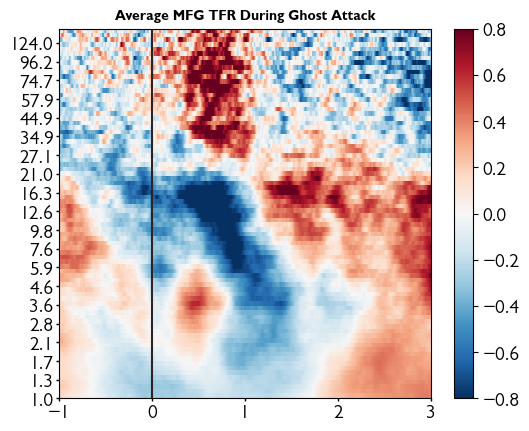

In [28]:
plot_allsub_averages(all_subs_average_dlpfc_conflict, "Average MFG TFR During Ghost Attack", 'average_mfg_ghost_attack_all_subs.png', -1, 3)

### Anterior Medial Frontal Gyrus

In [14]:
all_subs_average_dlpfcs = calculate_subregion_ghost_attack_average(mfg_sub_list, conditions, 'dlpfc', 'Amfg')
all_subs_average_dlpfc_conflict = all_subs_average_dlpfcs[0]


Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/ghost_attack/dlpfc-tfr.h5 ...


Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025'

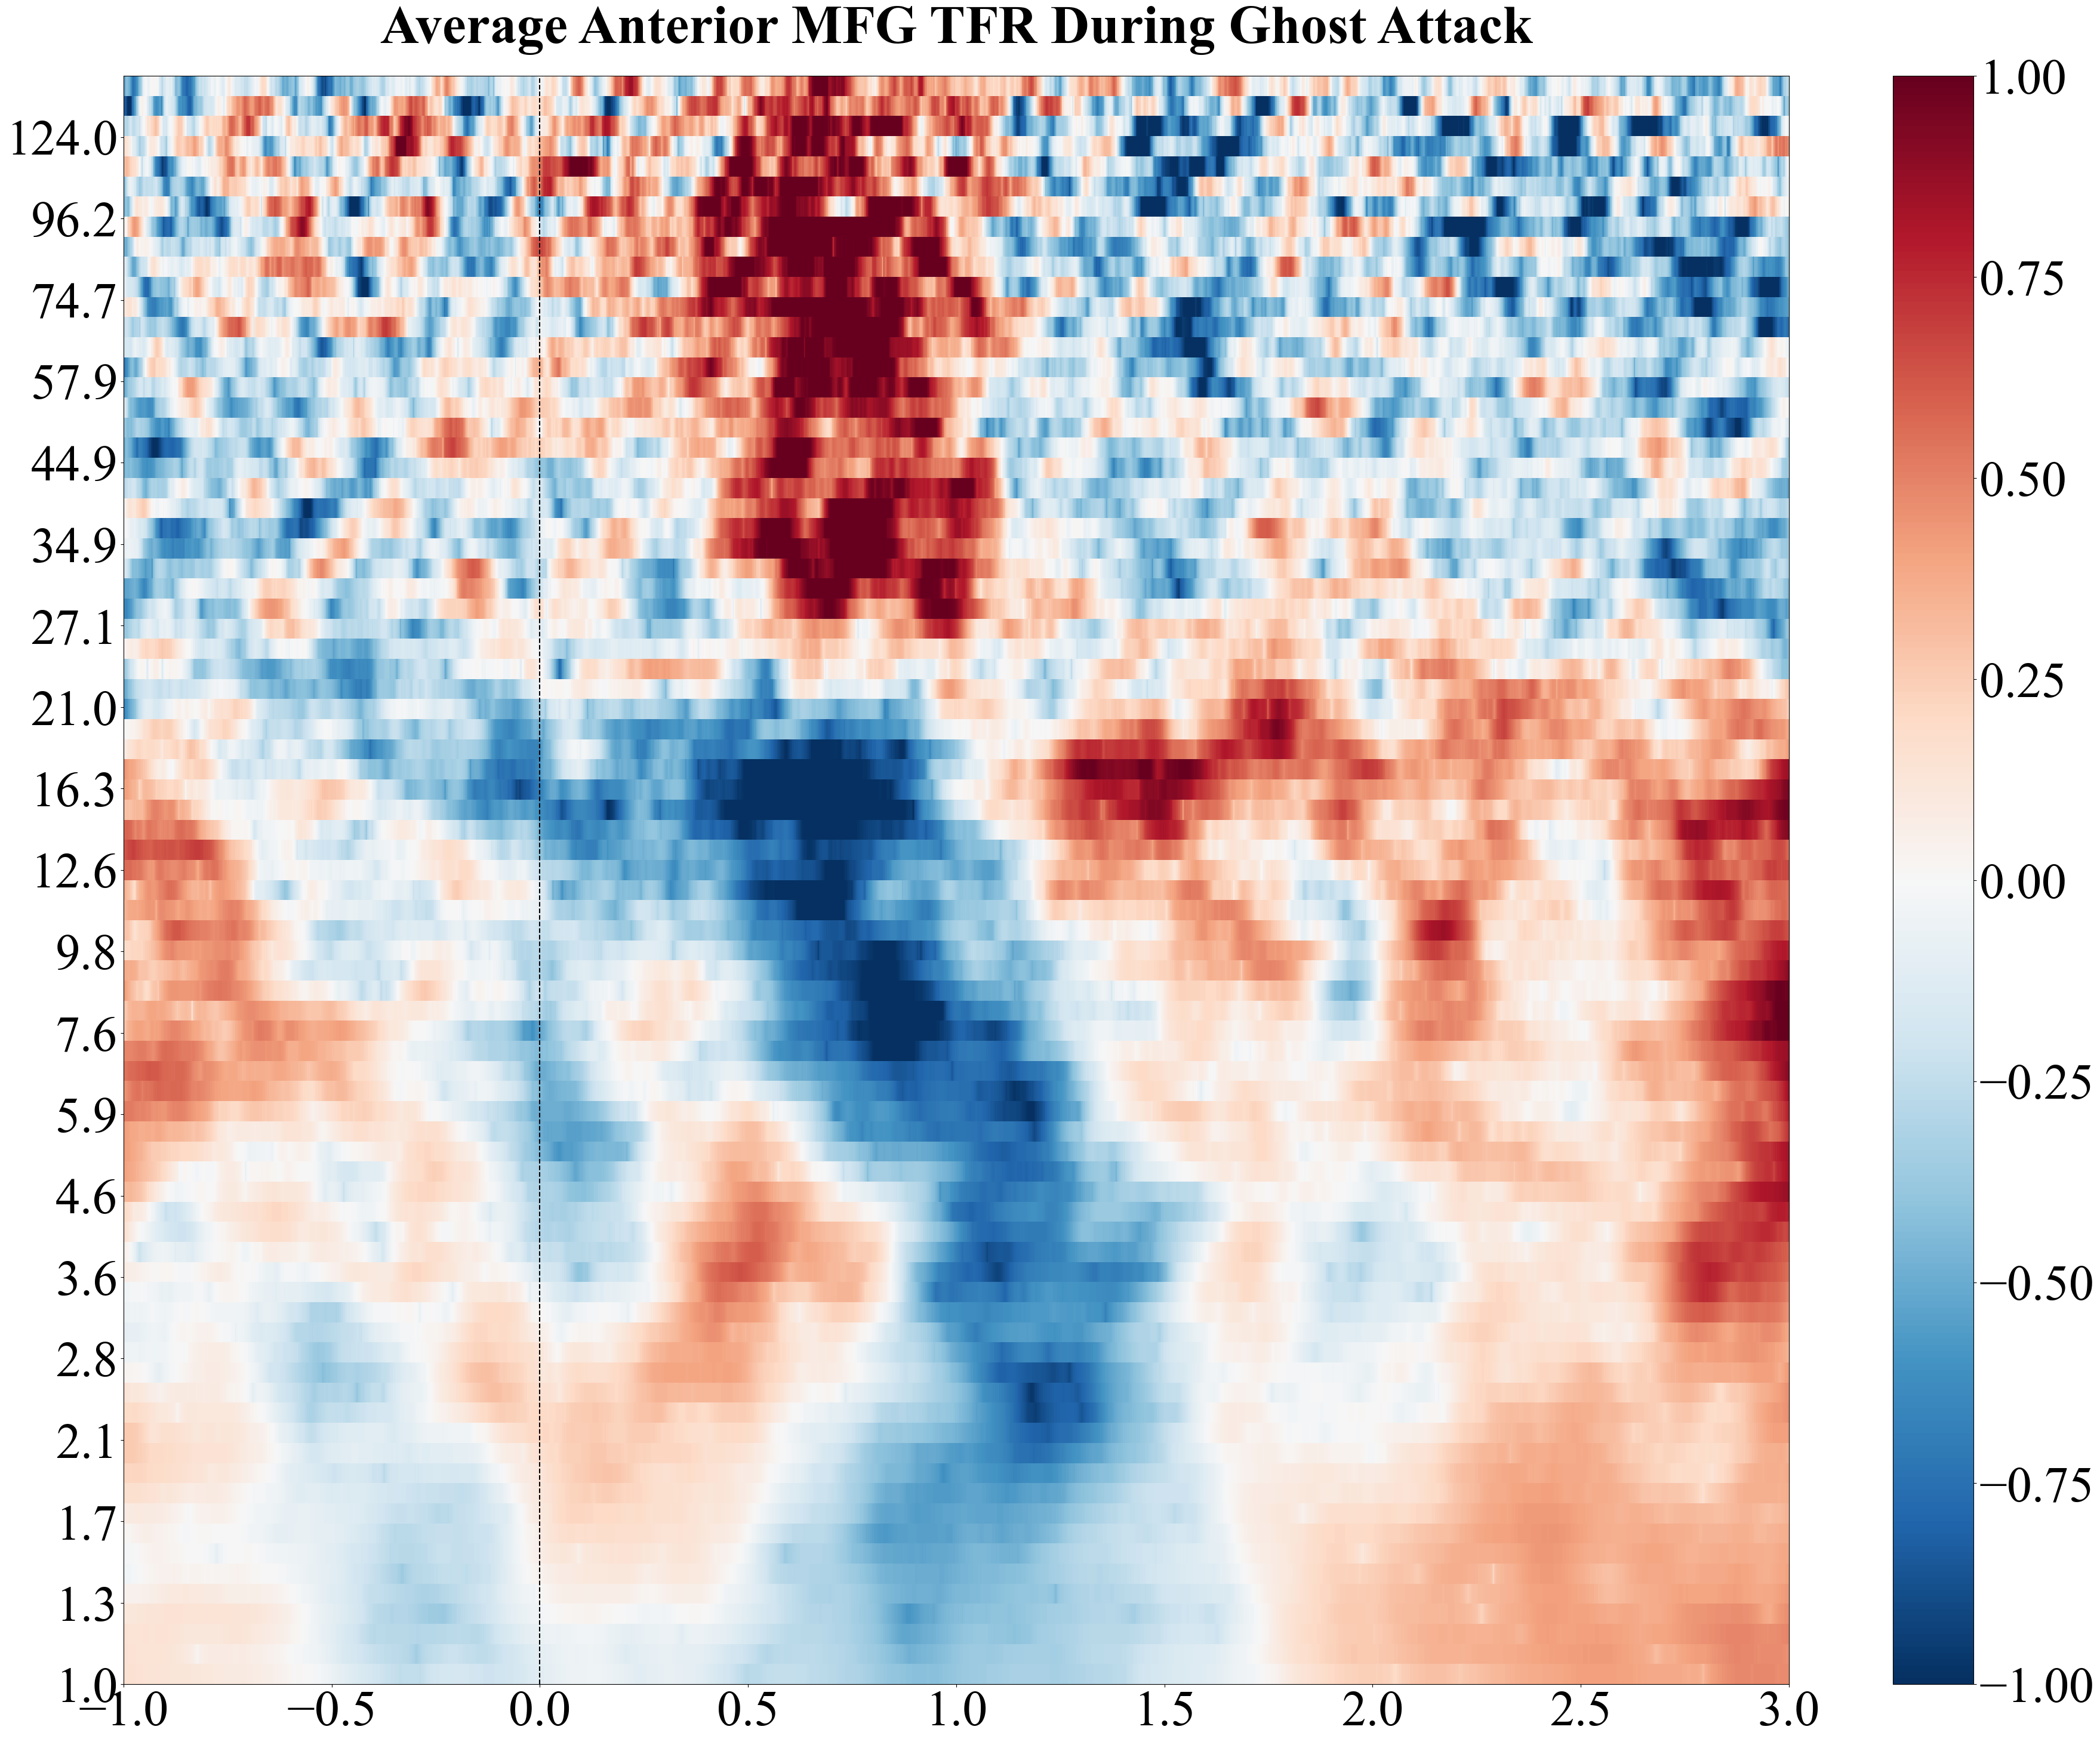

In [15]:
plot_allsub_averages(all_subs_average_dlpfc_conflict, "Average Anterior MFG TFR During Ghost Attack", 'average_anterior_mfg_ghost_attack_all_subs.png', -1, 3)

### Posterior Medial Frontal Gyrus

In [16]:
all_subs_average_dlpfcs = calculate_subregion_ghost_attack_average(mfg_sub_list, conditions, 'dlpfc', 'Pmfg')
all_subs_average_dlpfc_conflict = all_subs_average_dlpfcs[0]


Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/ghost_attack/dlpfc-tfr.h5 ...


Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025', 'BJH016', 'SLCH002']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH025'

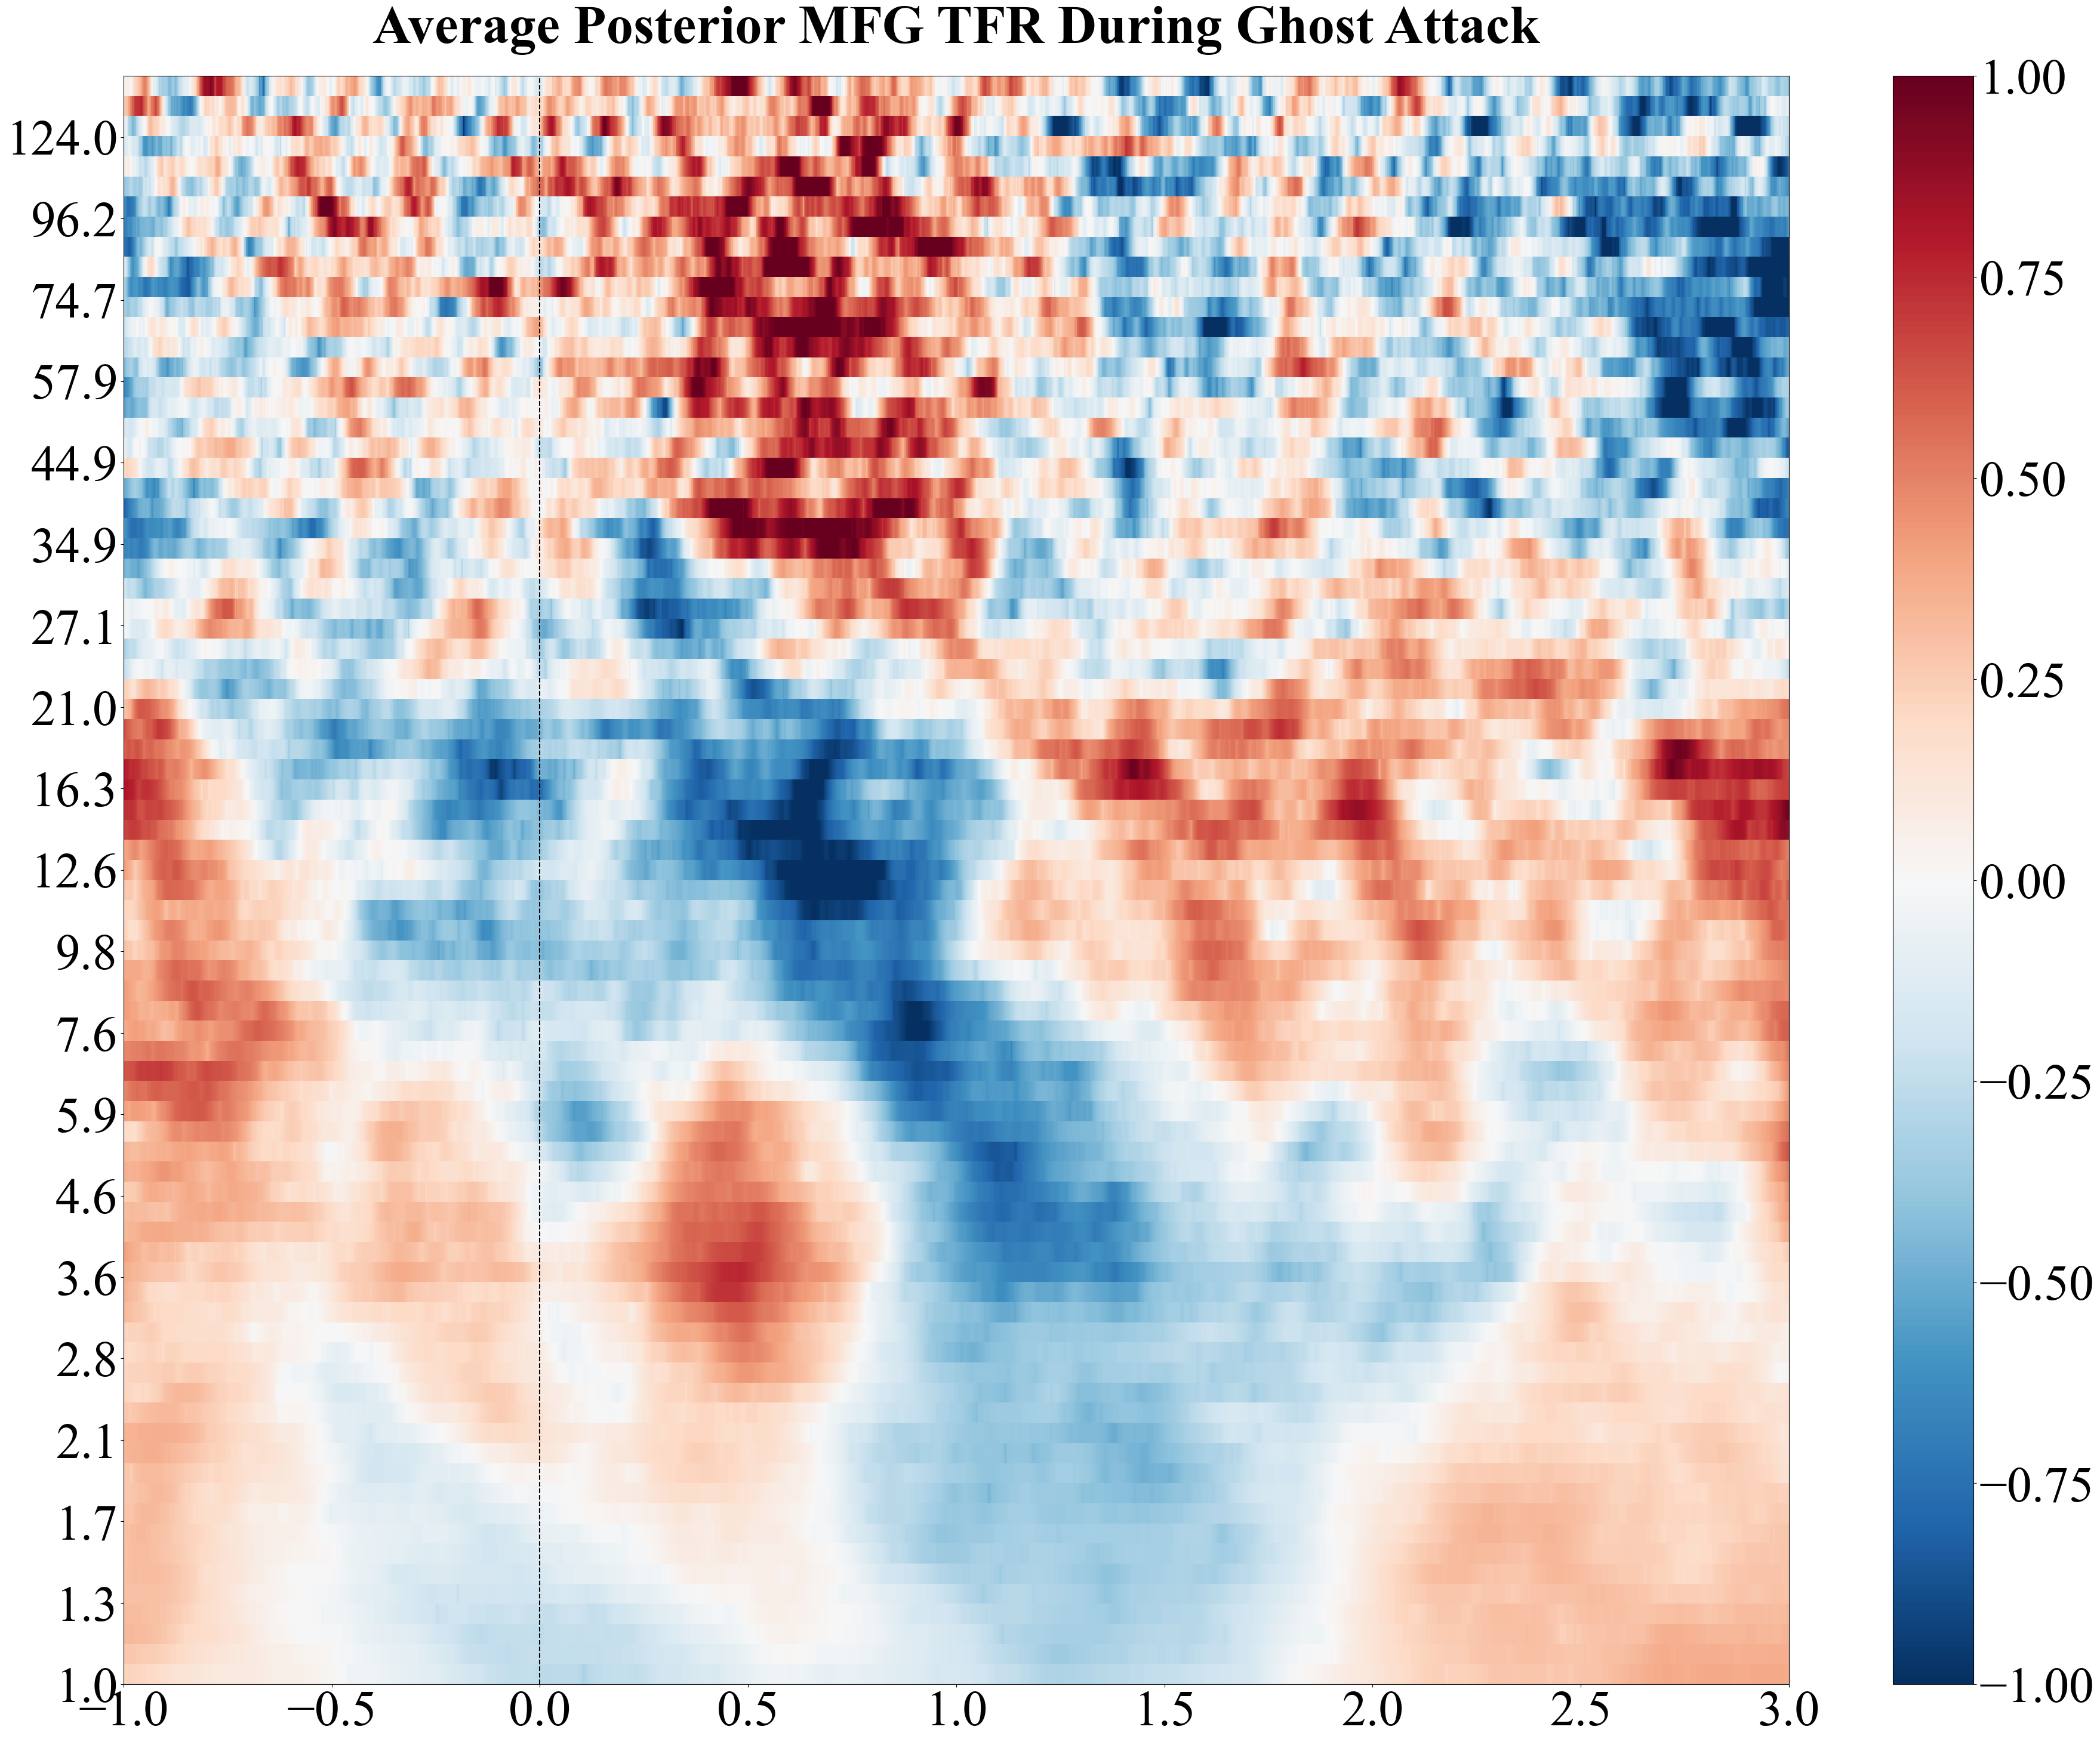

In [17]:
plot_allsub_averages(all_subs_average_dlpfc_conflict, "Average Posterior MFG TFR During Ghost Attack", 'average_posterior_mfg_ghost_attack_all_subs.png', -1, 3)

### Superior Frontal Gyrus

In [9]:
all_subs_average_dlpfcs = calculate_subregion_ghost_attack_average(sfg_sub_list, conditions, 'dlpfc', 'sfg')
all_subs_average_dlpfc_conflict = all_subs_average_dlpfcs[0]


Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/ghost_attack/dlpfc-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH046/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Replacing existing metadata with 5 columns
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH025', 'BJH046']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/LL12/ieeg/ghost_attack/dlpfc-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH025', 'BJH046', 'LL12']
Reading /home/brooke/knight_server/remote/bstavel/pacma

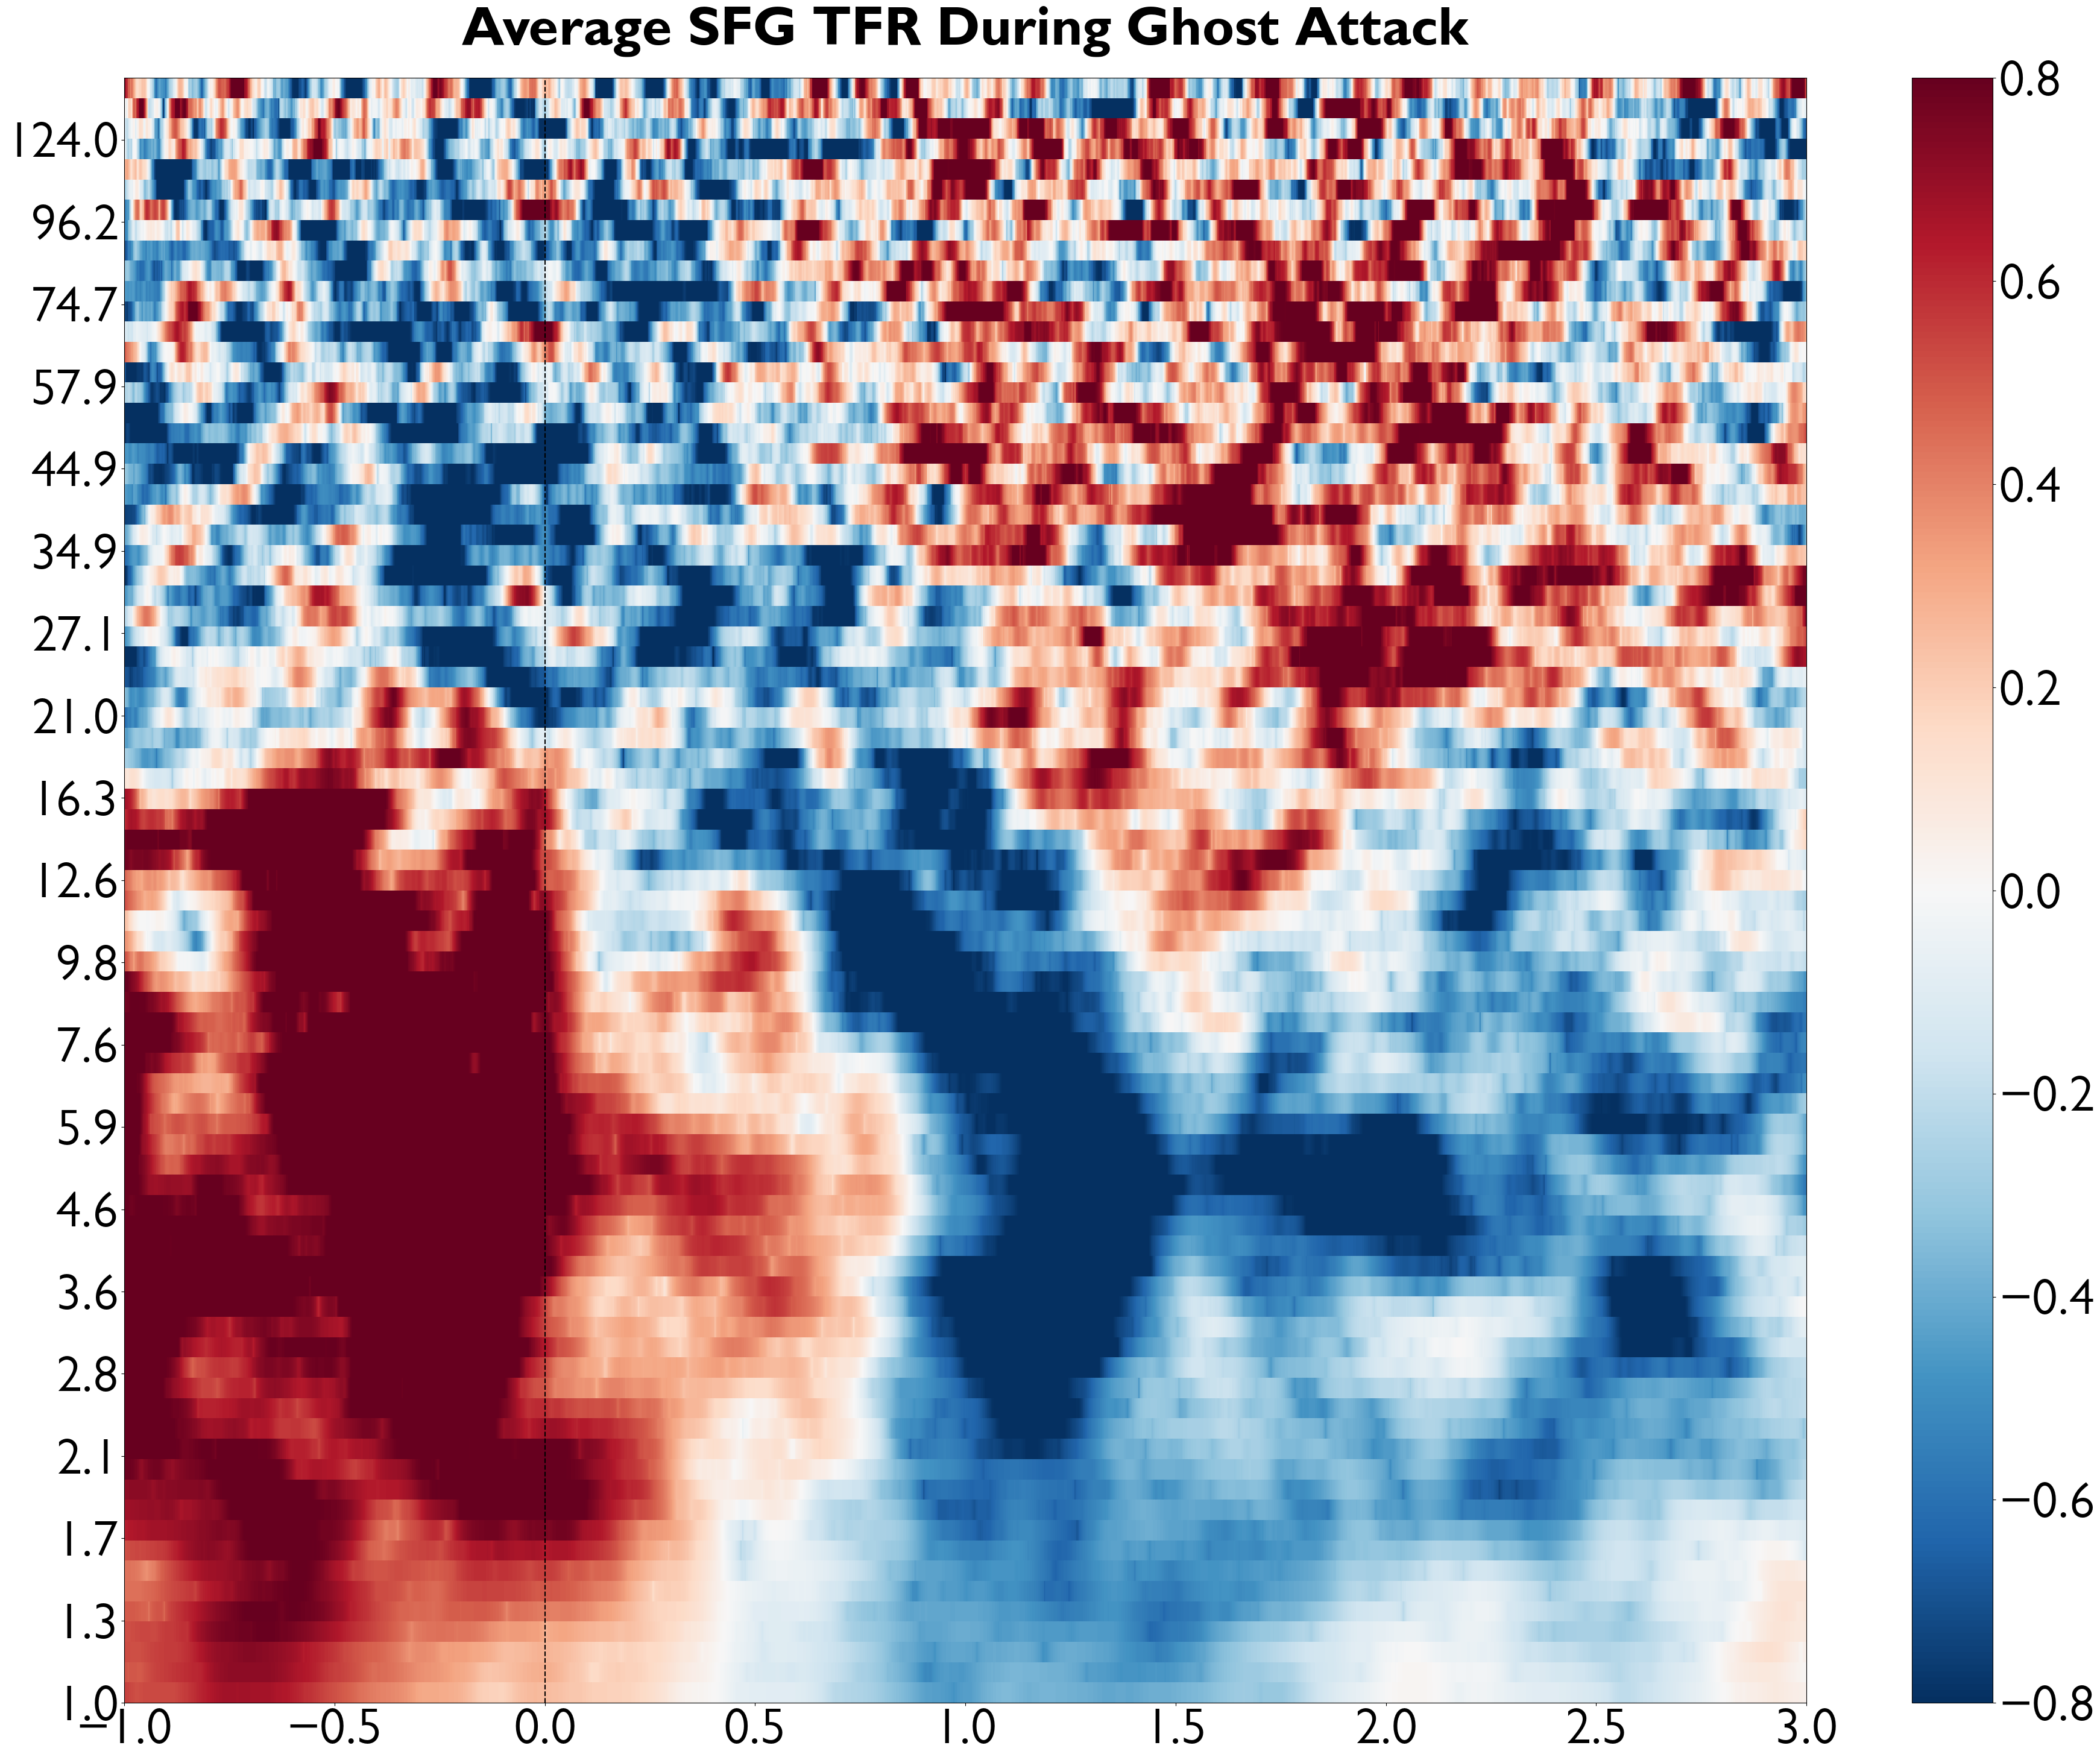

In [11]:
plot_allsub_averages(all_subs_average_dlpfc_conflict, "Average SFG TFR During Ghost Attack", 'average_sfg_ghost_attack_all_subs.png', -1, 3)

### Anterior Superior Frontal Gyrus

In [20]:
all_subs_average_dlpfcs = calculate_subregion_ghost_attack_average(sfg_sub_list, conditions, 'dlpfc', 'Asfg')
all_subs_average_dlpfc_conflict = all_subs_average_dlpfcs[0]


Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/ghost_attack/dlpfc-tfr.h5 ...


Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/LL12/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025', 'LL12']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/LL13/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025', 'LL12', 'LL13']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/LL14/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025', 'LL12', 'LL13', 'LL14']


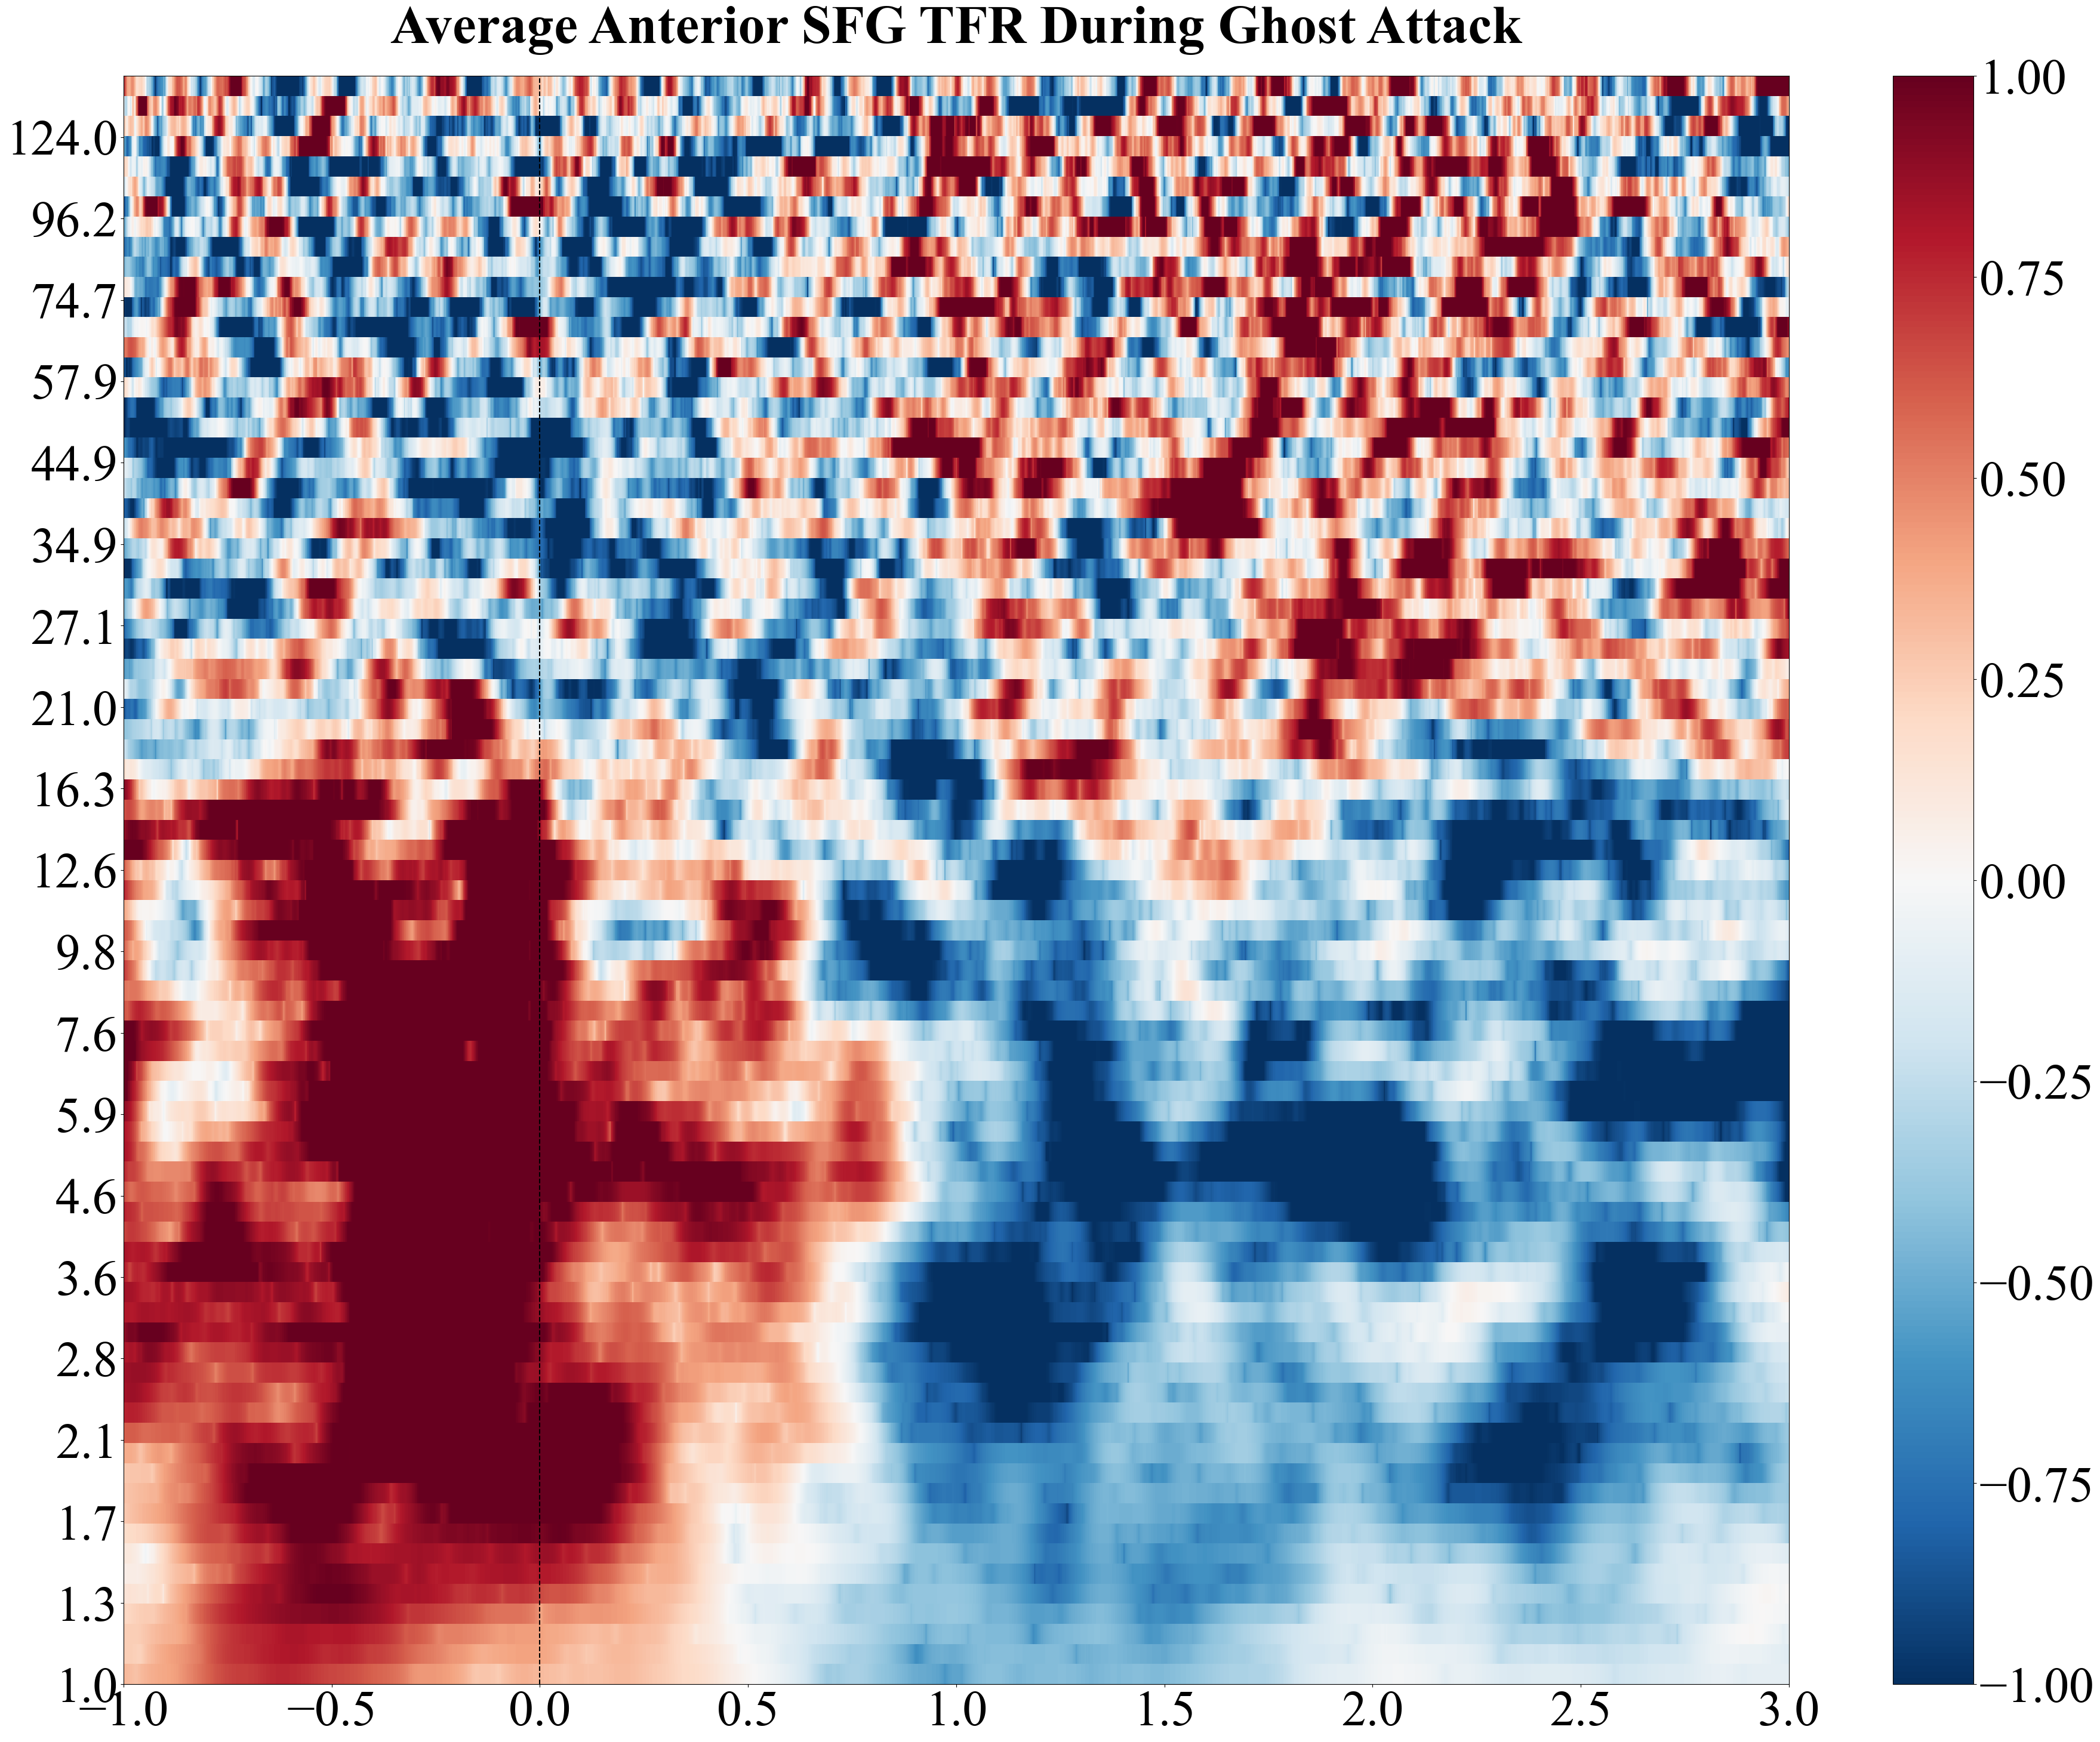

In [21]:
plot_allsub_averages(all_subs_average_dlpfc_conflict, "Average Anterior SFG TFR During Ghost Attack", 'average_anterior_sfg_ghost_attack_all_subs.png', -1, 3)

### Posterior Superior Frontal Gyrus

In [22]:
all_subs_average_dlpfcs = calculate_subregion_ghost_attack_average(sfg_sub_list, conditions, 'dlpfc', 'Psfg')
all_subs_average_dlpfc_conflict = all_subs_average_dlpfcs[0]


Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/ghost_attack/dlpfc-tfr.h5 ...


Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/LL12/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025', 'LL12']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/LL13/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025', 'LL12', 'LL13']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/LL14/ieeg/ghost_attack/dlpfc-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH025', 'LL12', 'LL13', 'LL14']


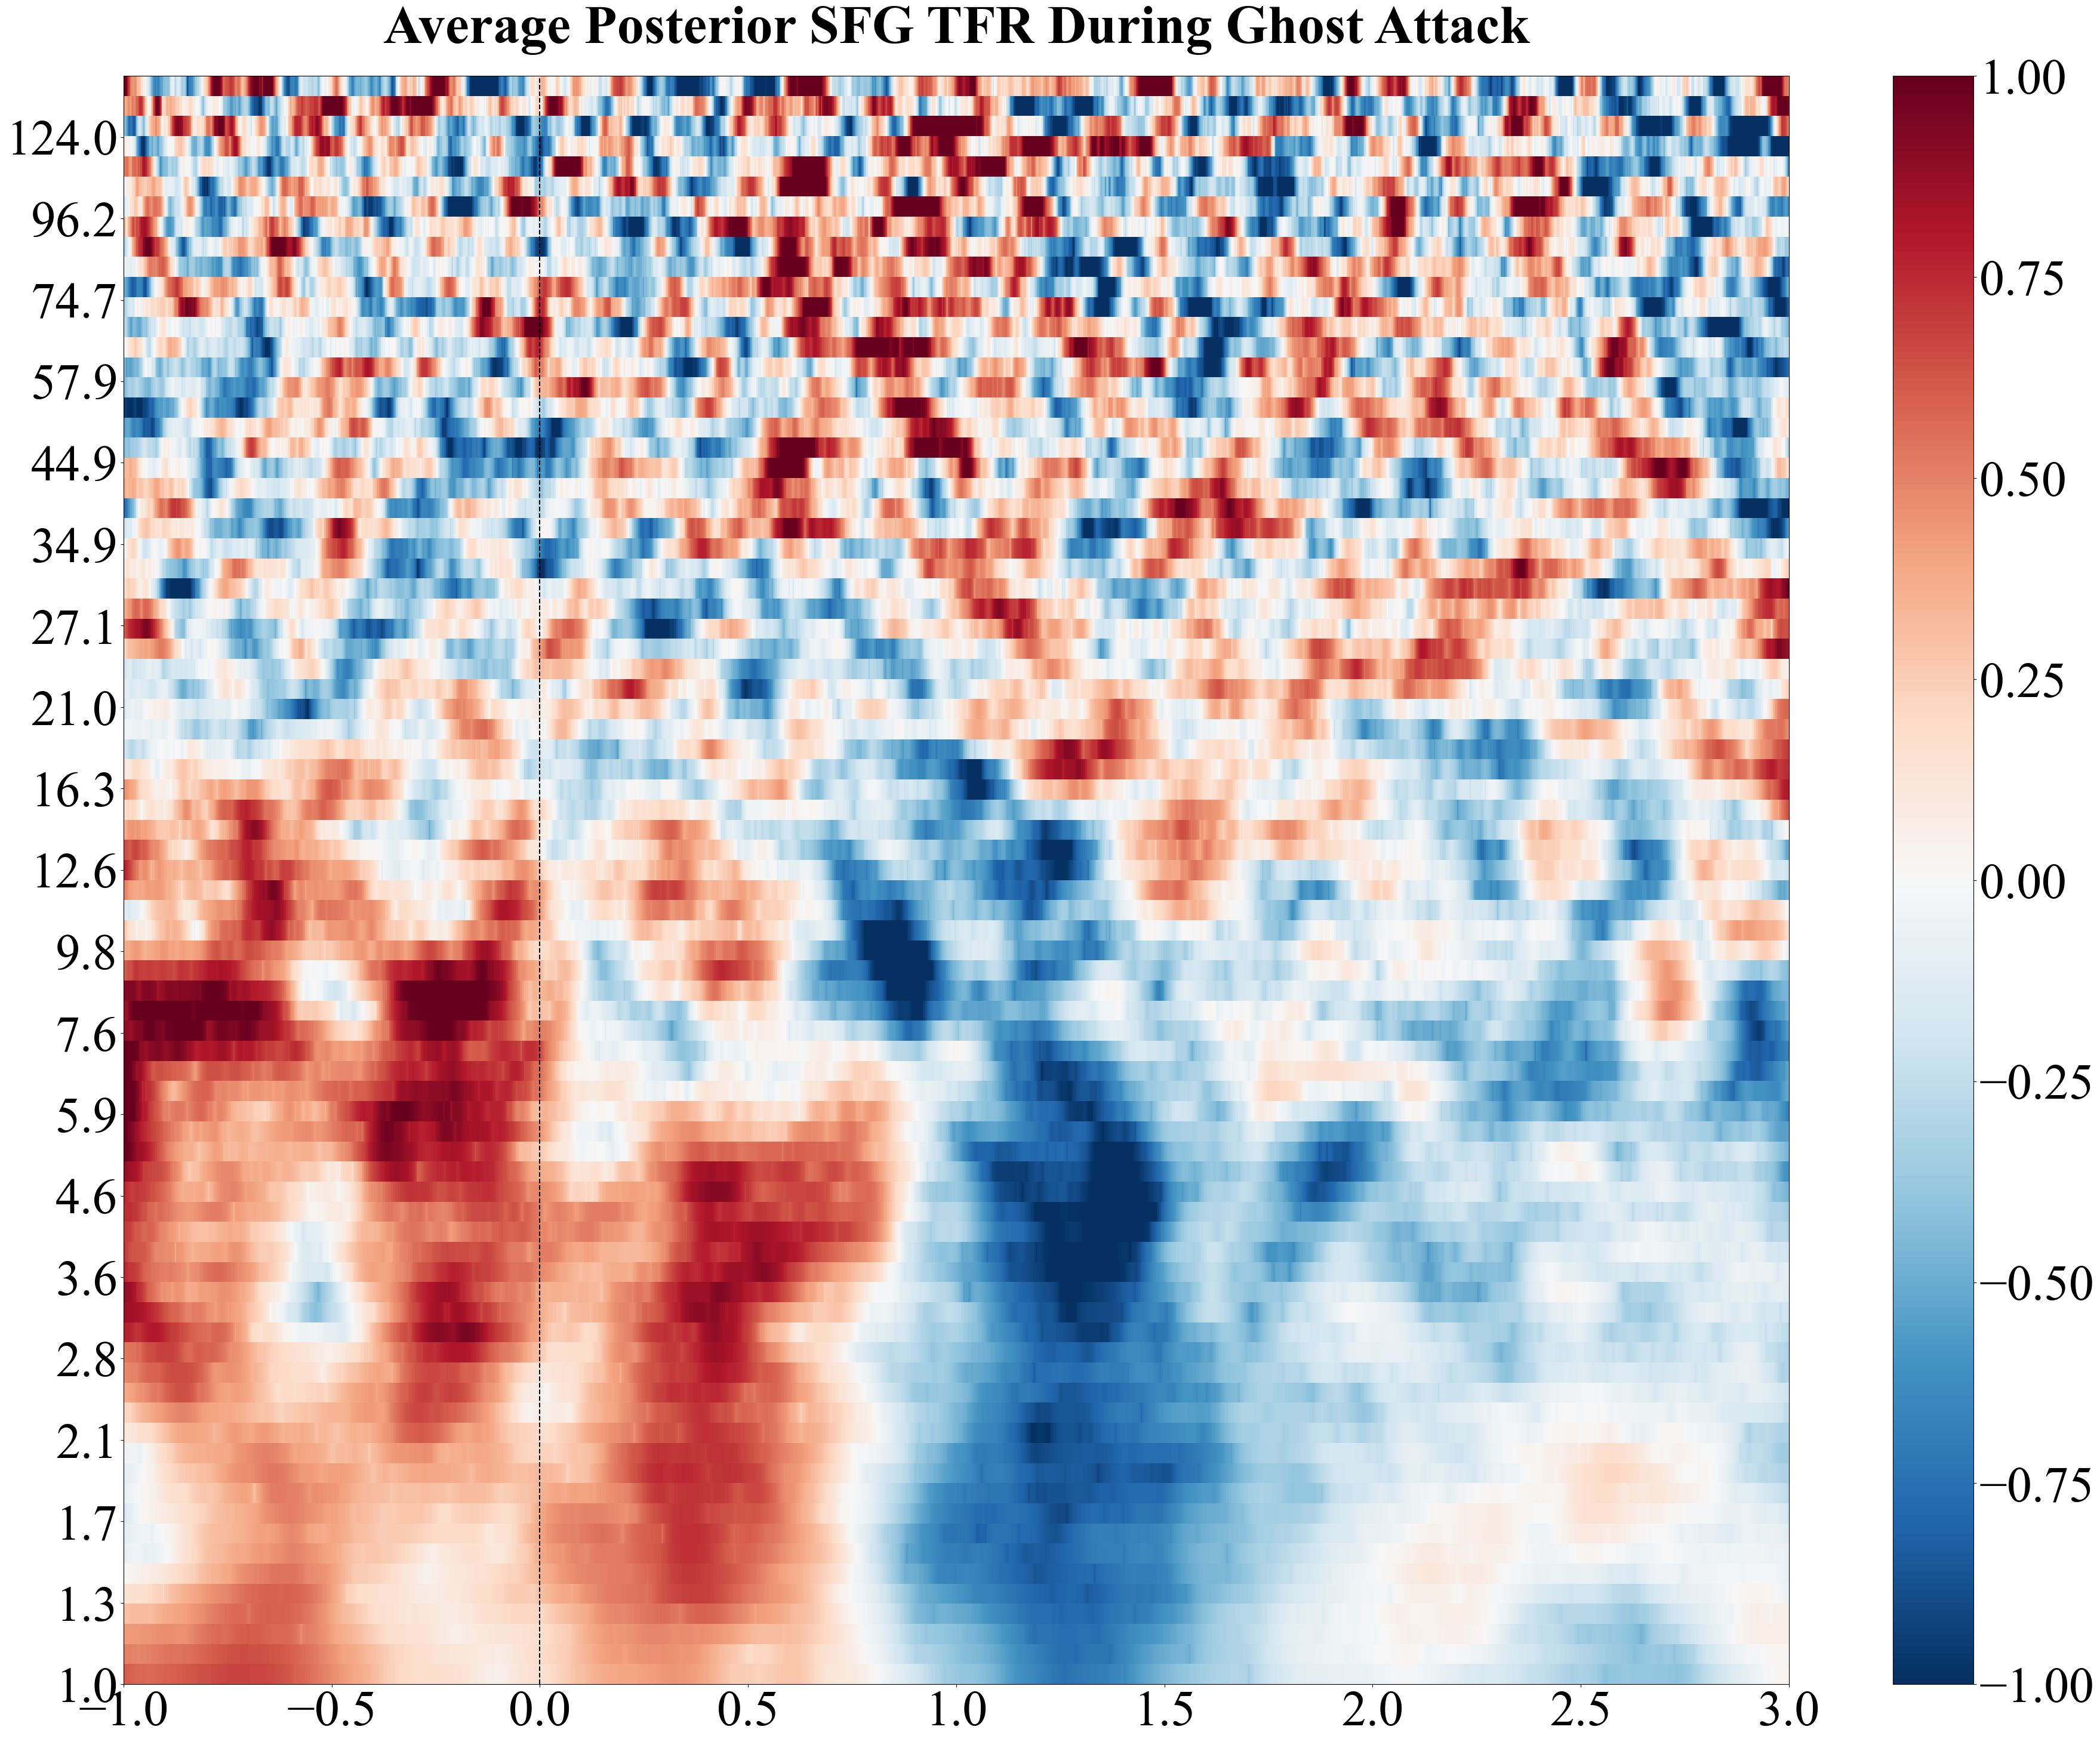

In [23]:
plot_allsub_averages(all_subs_average_dlpfc_conflict, "Average Posterior SFG TFR During Ghost Attack", 'average_posterior_sfg_ghost_attack_all_subs.png', -1, 3)

### Left Hippocampus

In [13]:
all_subs_average_hcs = calculate_subregion_ghost_attack_average(Lhc_sub_list, conditions, 'hc', 'Lhc')
all_subs_average_hc_conflict = all_subs_average_hcs[0]

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/ghost_attack/hc-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/ghost_attack/hc-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/ghost_attack/hc-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021', 'BJH025', 'BJH016']
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH027/ieeg/ghost_attack/hc-tfr.h5 ...
log transforming
z-scorin

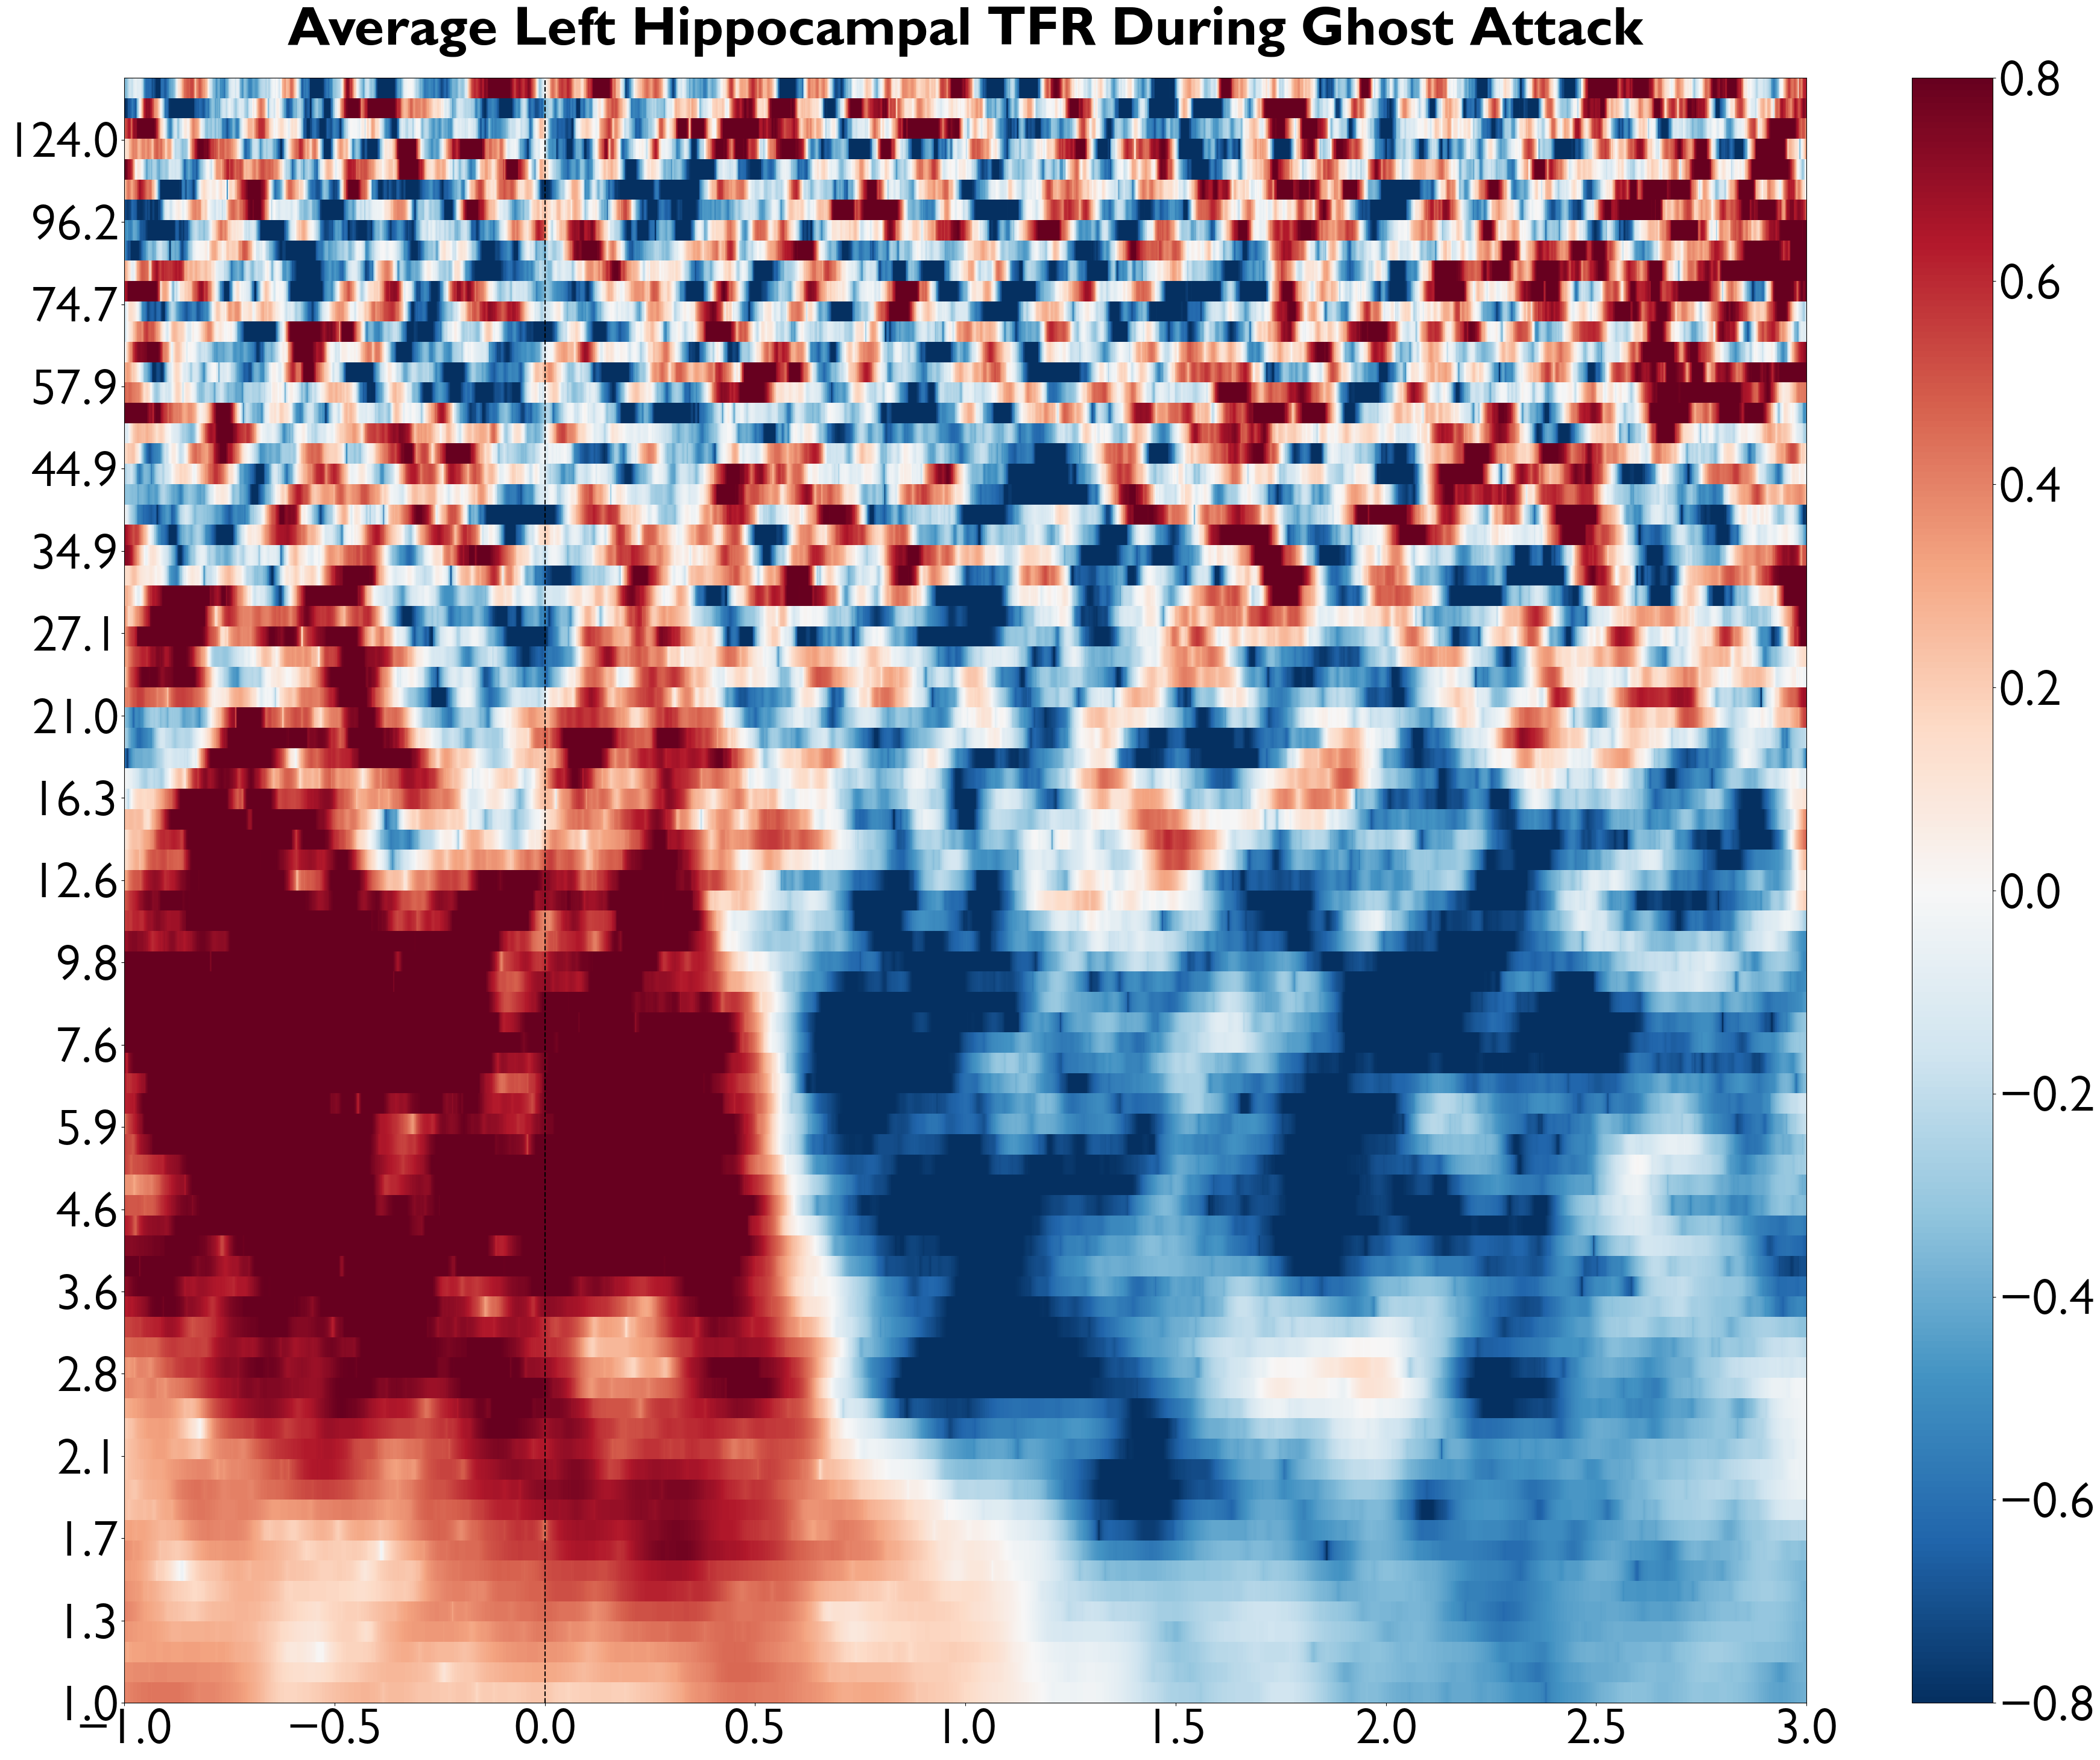

In [14]:
plot_allsub_averages(all_subs_average_hc_conflict, "Average Left Hippocampal TFR During Ghost Attack", 'average_Lhc_ghost_attack_all_subs.png', -1, 3)

### Right Hippocampus

In [15]:
all_subs_average_hcs = calculate_subregion_ghost_attack_average(Rhc_sub_list, conditions, 'hc', 'Rhc')
all_subs_average_hc_conflict = all_subs_average_hcs[0]

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/ghost_attack/hc-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/ghost_attack/hc-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/ghost_attack/hc-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH027/ieeg/ghost_attack/hc-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy fu

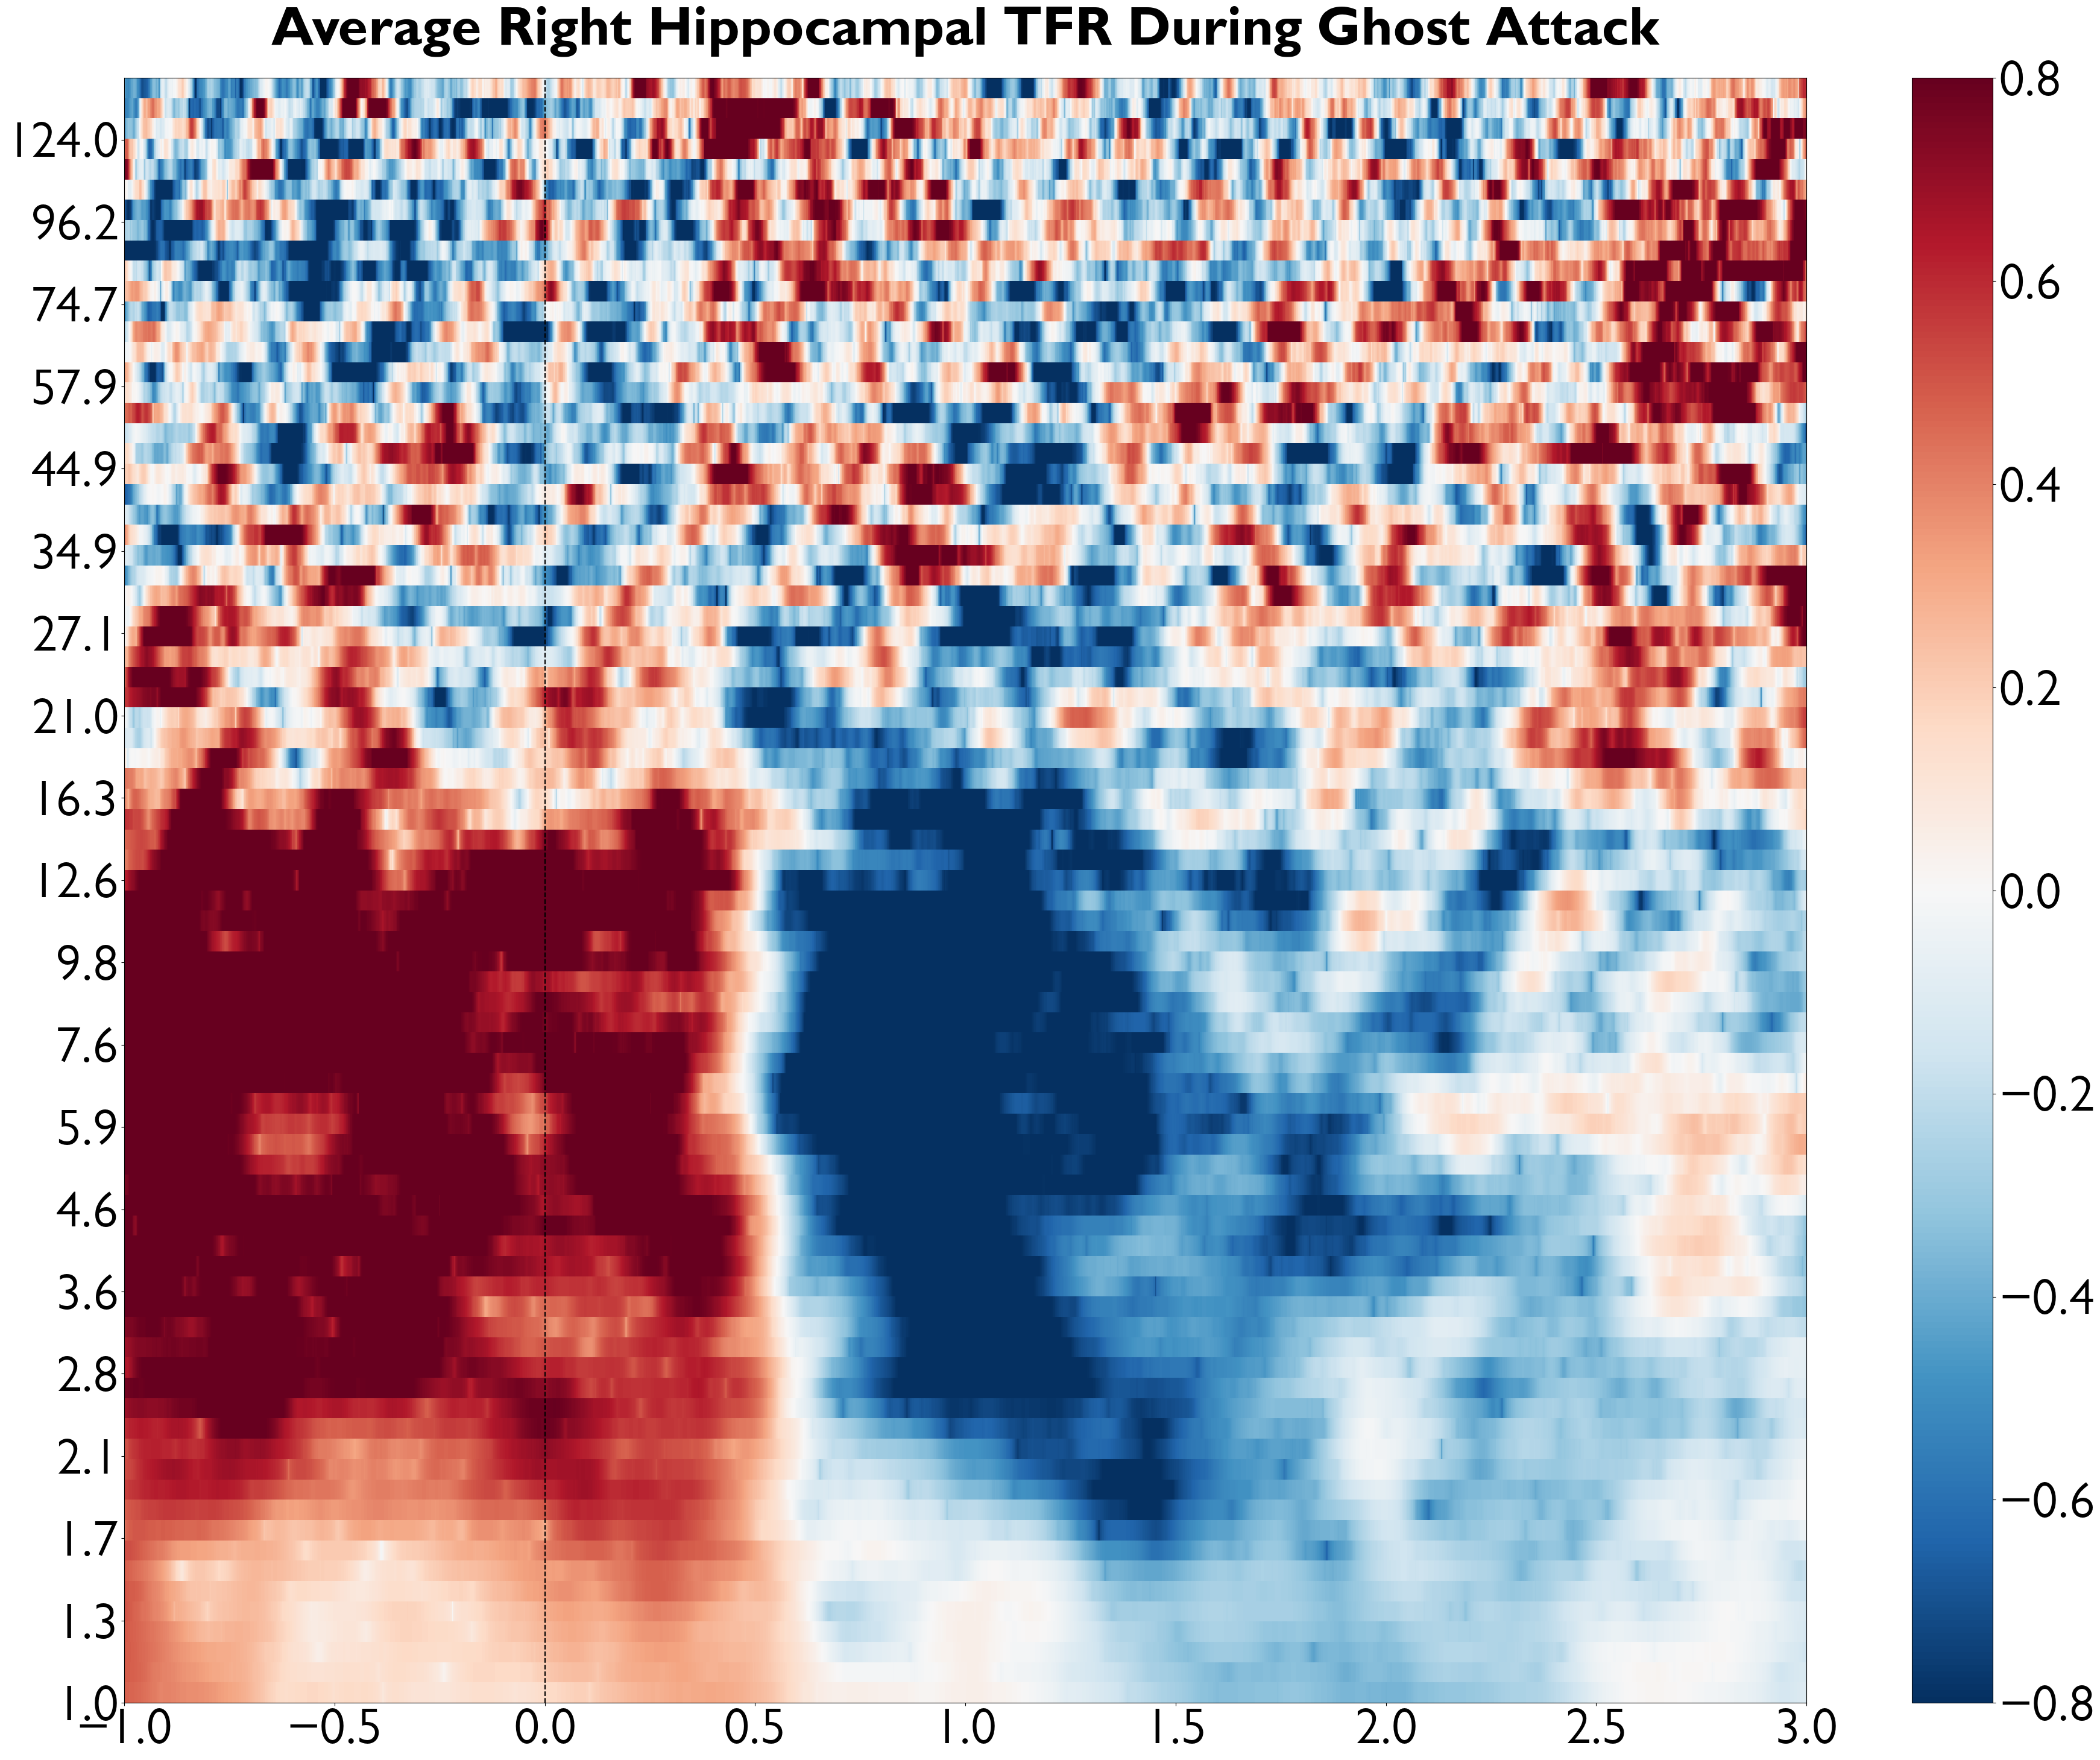

In [17]:
plot_allsub_averages(all_subs_average_hc_conflict, "Average Right Hippocampal TFR During Ghost Attack", 'average_Rhc_ghost_attack_all_subs.png', -1, 3)

## OFC

In [ ]:
all_subs_average_ofcs = calculate_ghost_attack_average(sub_list, conditions, 'ofc')
all_subs_average_ofc_conflict = all_subs_average_ofcs[0]


In [ ]:
plot_allsub_averages(all_subs_average_ofc_conflict, "Average OFC TFR During Ghost Attack", 'average_ofc_ghost_attack_all_subs.png', -1, 3)

## Anterior Cingulate

### Subgenual Anterior Cingulate Cortex

In [22]:
all_subs_average_cings = calculate_subregion_ghost_attack_average(sgACC_sub_list, conditions, 'cing' , 'sgACC')
all_subs_average_cing_conflict = all_subs_average_cings[0]


Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/ghost_attack/cing-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/ghost_attack/cing-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/ghost_attack/cing-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH025', 'BJH016', 'SLCH002']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/ghost_attack/cing-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a l

KeyError: 'BJH017'

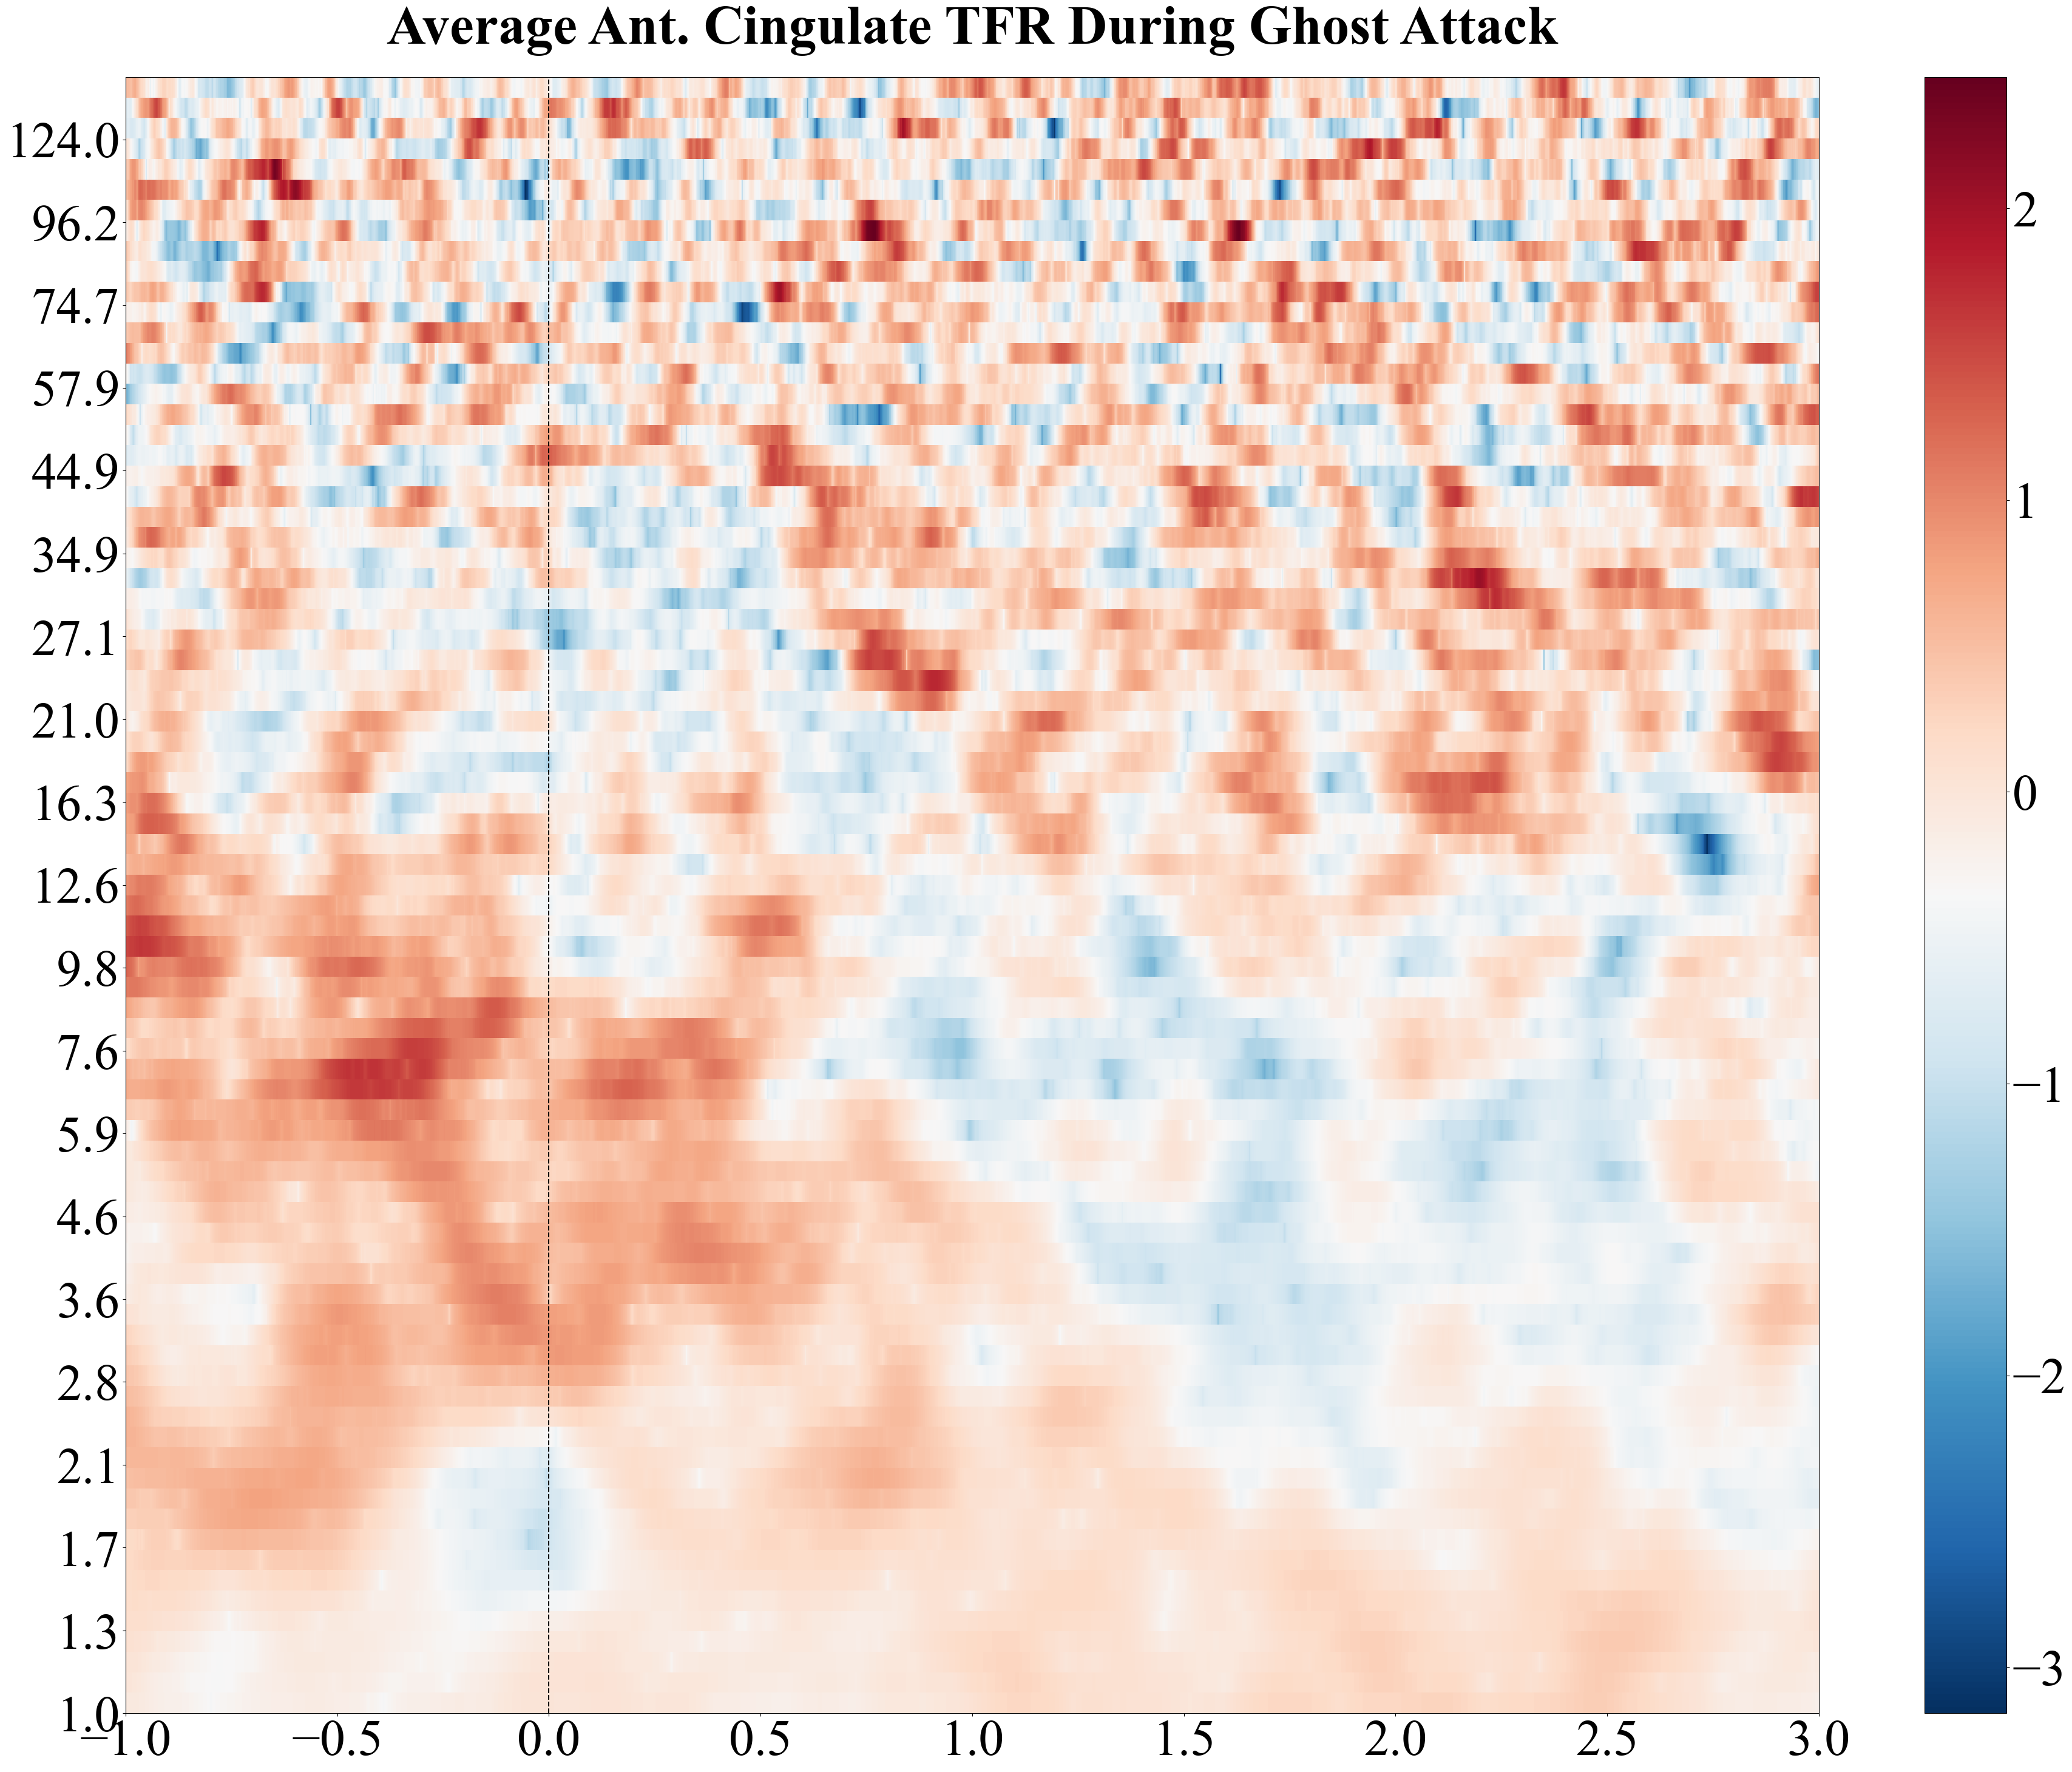

In [17]:
plot_allsub_averages(all_subs_average_cing_conflict, "Average sgACC TFR During Ghost Attack", 'average_cing_ghost_attack_all_subs.png', -1, 3)

### Dorsal Anterior Cingulate Cortex

In [7]:
all_subs_average_cings = calculate_subregion_ghost_attack_average(dACC_sub_list, conditions, 'cing' , 'dACC')
all_subs_average_cing_conflict = all_subs_average_cings[0]

Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/ghost_attack/cing-tfr.h5 ...


Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/ghost_attack/cing-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH016']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/BJH039/ieeg/ghost_attack/cing-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH016', 'BJH039']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/LL12/ieeg/ghost_attack/cing-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH016', 'BJH039', 'LL12']
Reading /mnt/knight_server/remote/bstavel/pacman/preprocessing/LL13/ieeg/ghost_attack/cing-tfr.h5 ...
Adding metadata with 5 columns
log transforming
z-scoring to baseline
currently used subs: ['BJH021', 'BJH016', 'BJH039', 

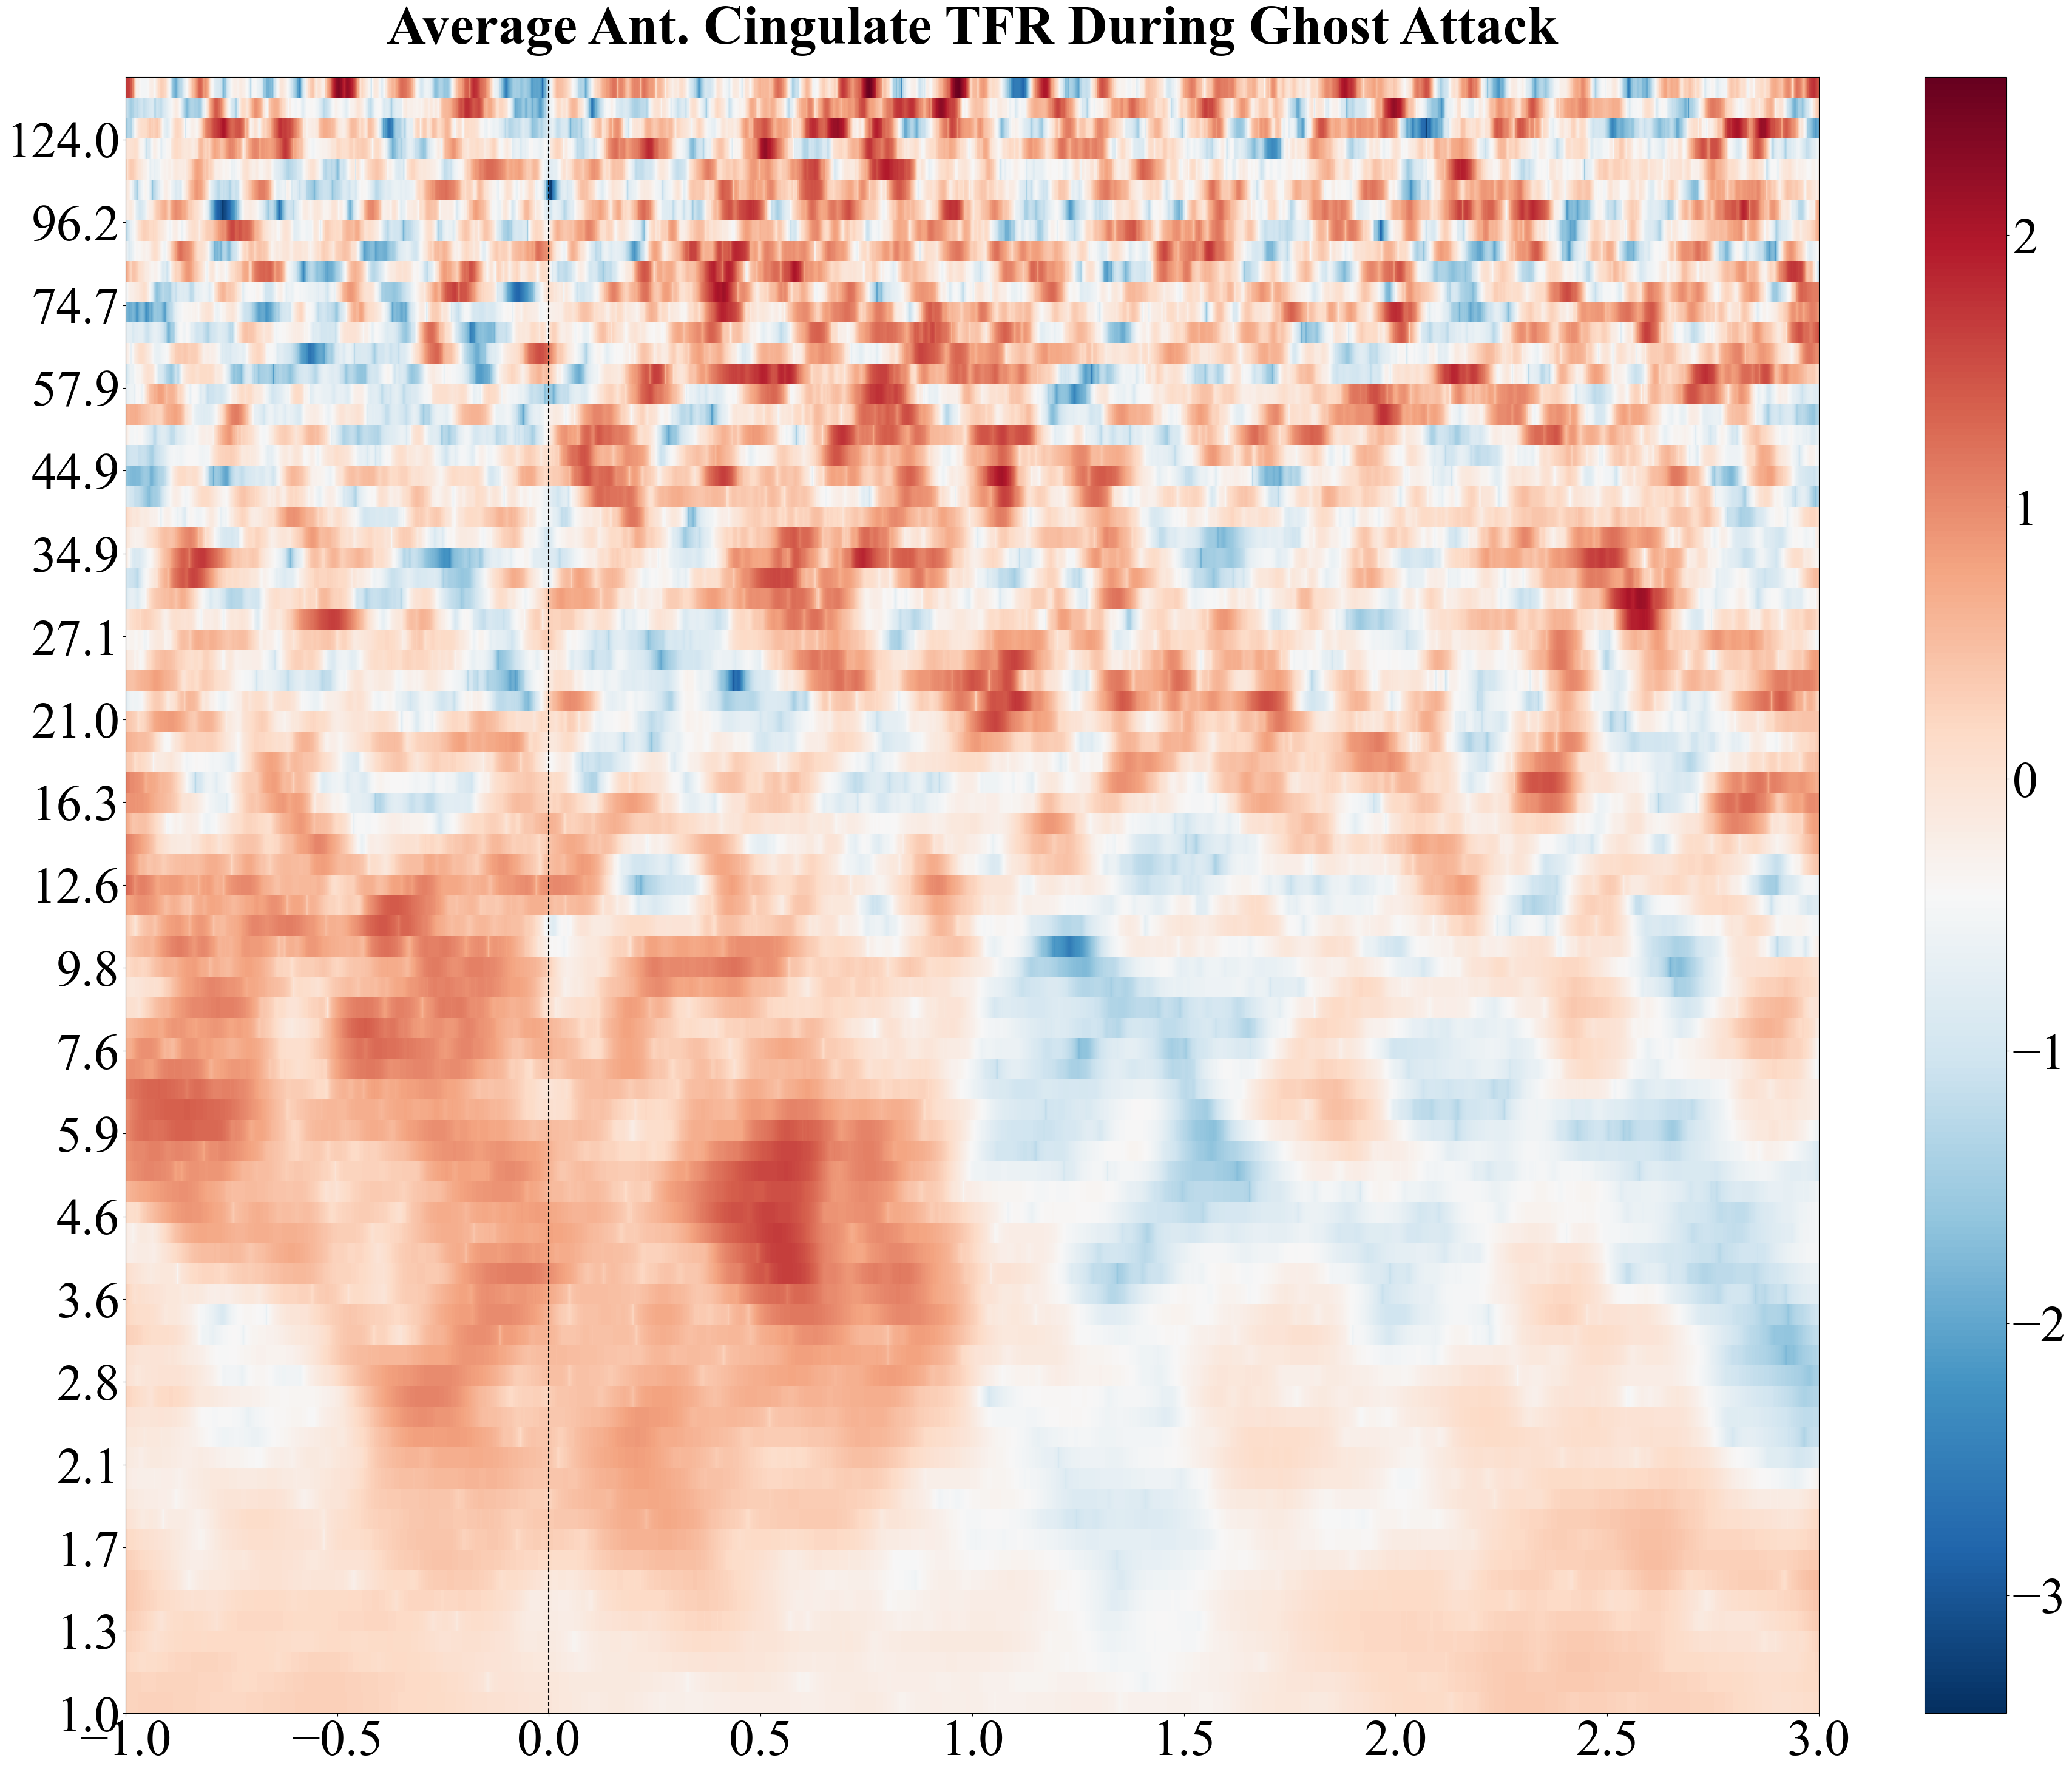

In [8]:
plot_allsub_averages(all_subs_average_cing_conflict, "Average dACC TFR During Ghost Attack", 'average_cing_ghost_attack_all_subs.png', -1, 3)

## Amygdala

### Left Amygdala

In [18]:
all_subs_average_amygs = calculate_subregion_ghost_attack_average(Lamyg_sub_list, conditions, 'amyg', 'Lamyg')
all_subs_average_amyg_conflict = all_subs_average_amygs[0]


Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/ghost_attack/amyg-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/ghost_attack/amyg-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/ghost_attack/amyg-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/ghost_attack/amyg-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a leg

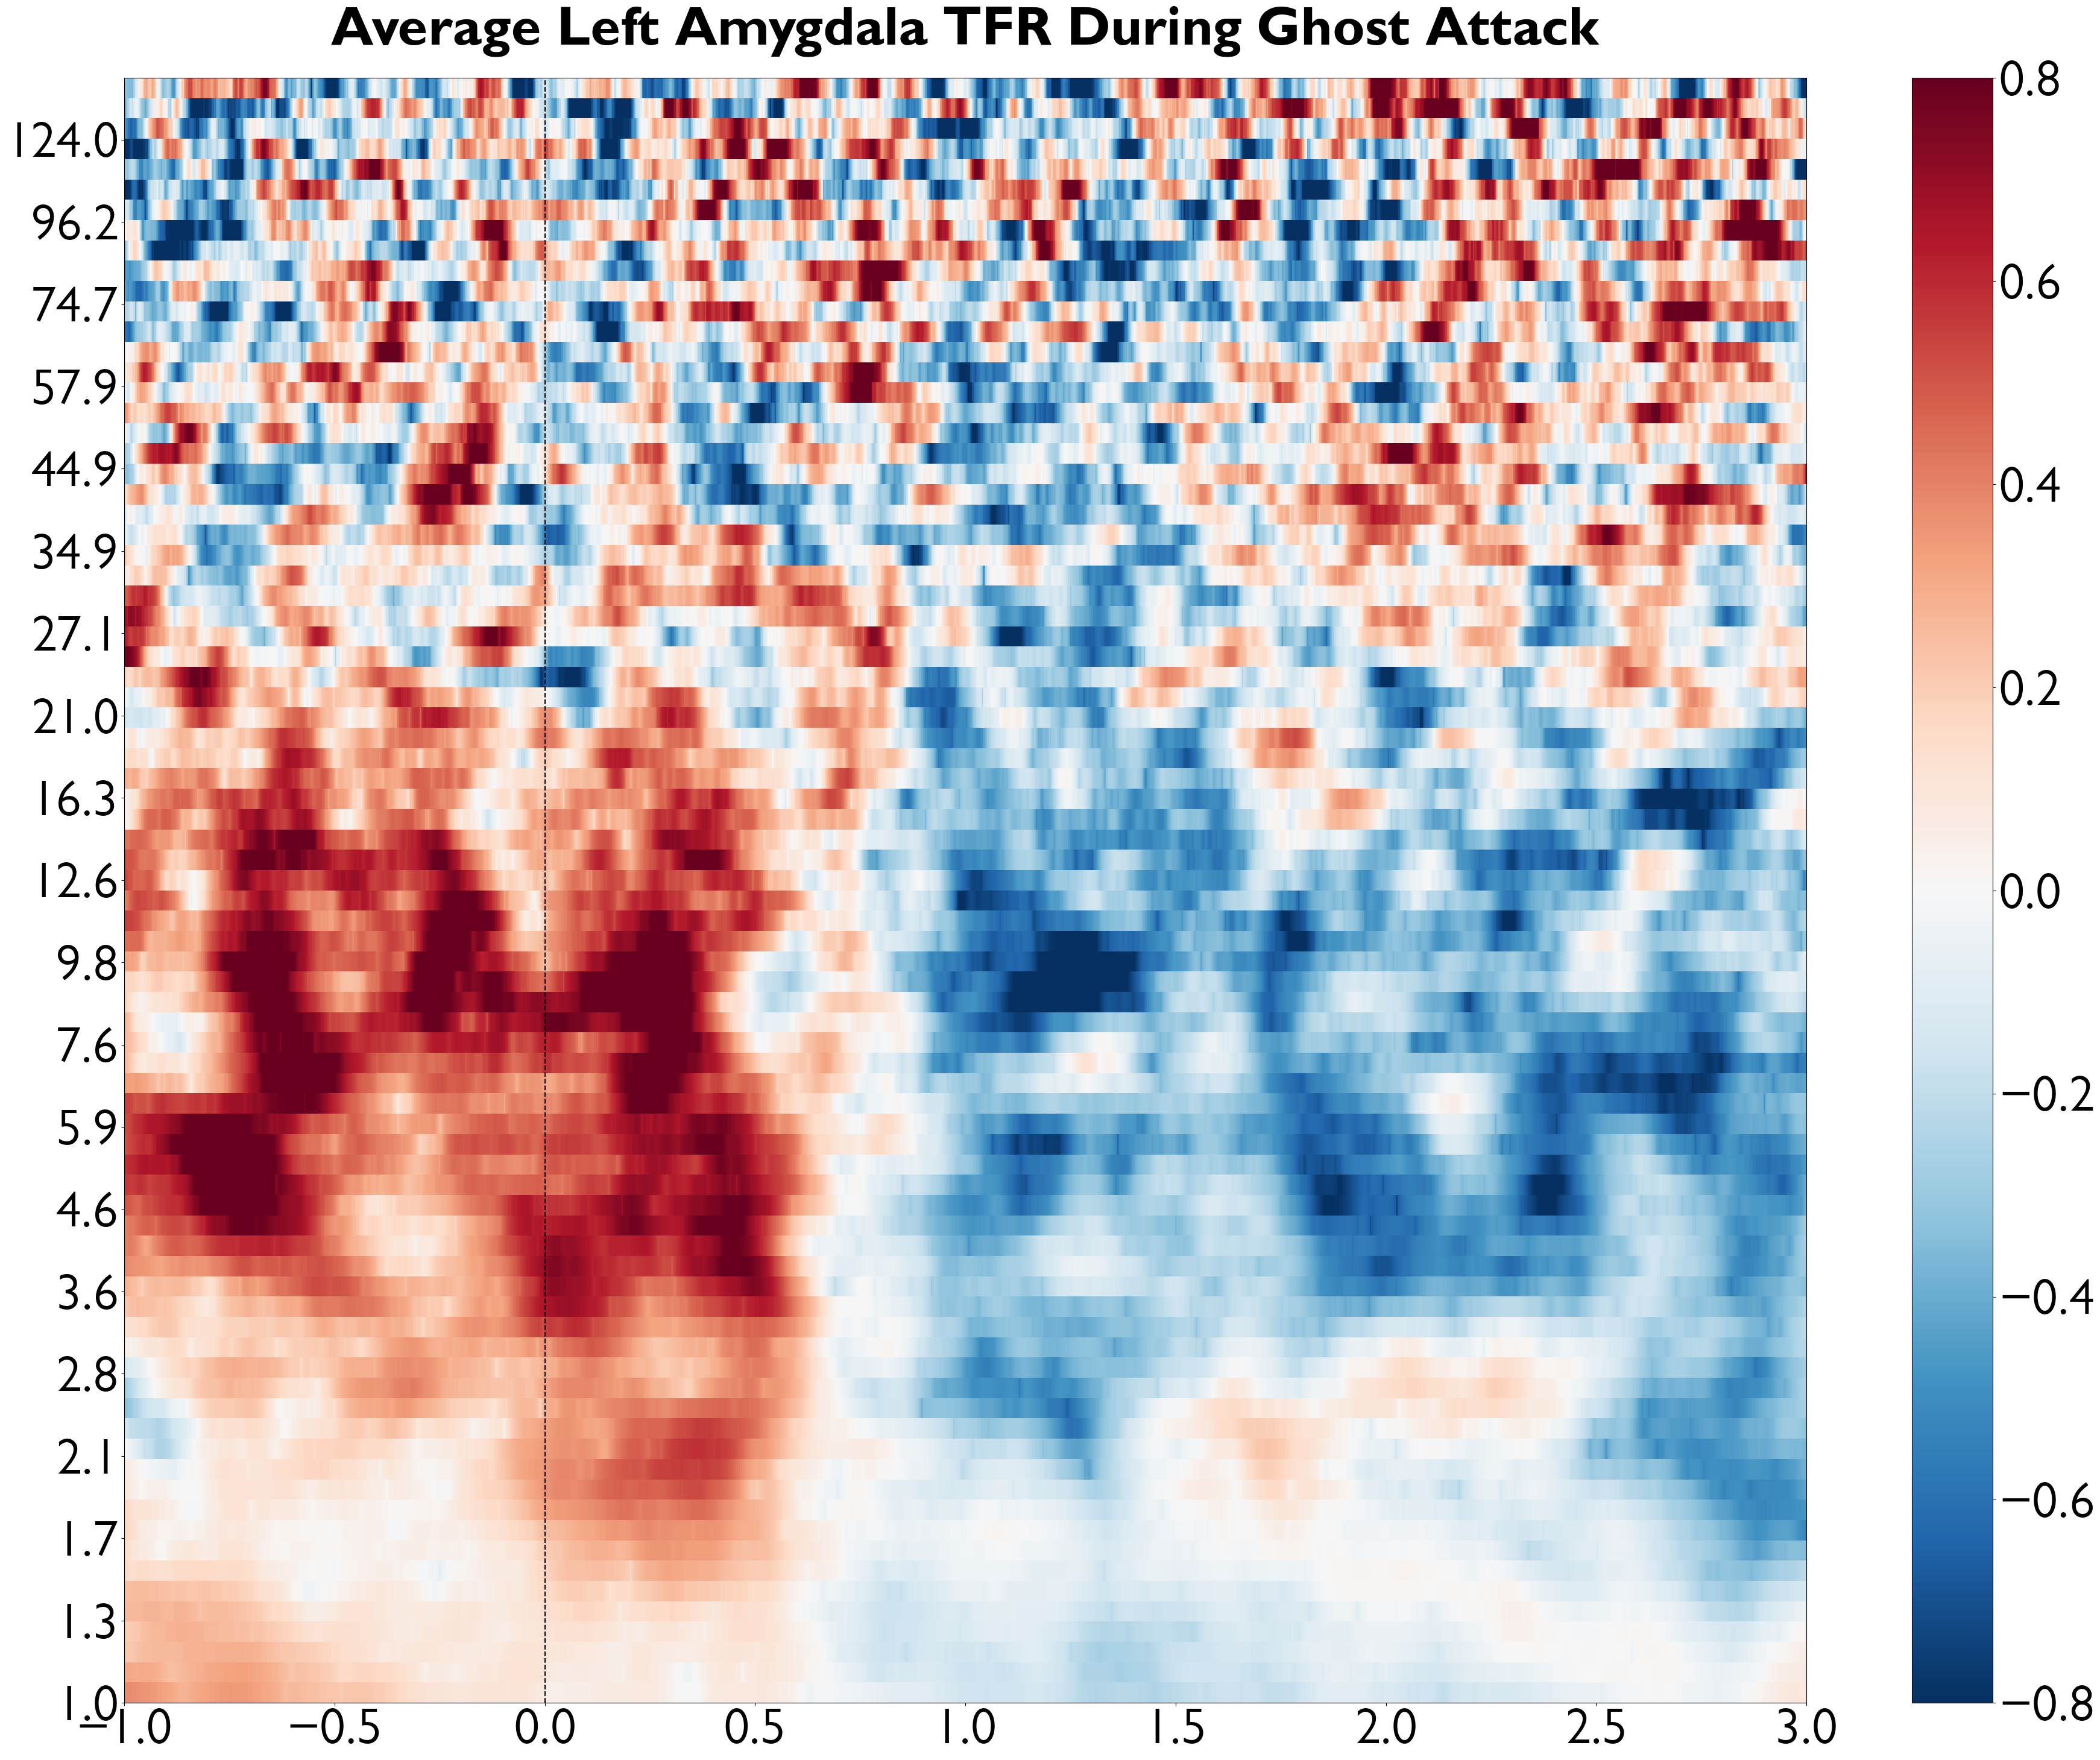

In [19]:
plot_allsub_averages(all_subs_average_amyg_conflict, "Average Left Amygdala TFR During Ghost Attack", 'average_Lamyg_ghost_attack_all_subs.png', -1, 3)

### Right Amygdala

In [20]:
all_subs_average_amygs = calculate_subregion_ghost_attack_average(Ramyg_sub_list, conditions, 'amyg', 'Ramyg')
all_subs_average_amyg_conflict = all_subs_average_amygs[0]


Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/ghost_attack/amyg-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/ghost_attack/amyg-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021', 'BJH025']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/ghost_attack/amyg-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
currently used subs: ['BJH021', 'BJH025', 'BJH016']
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH026/ieeg/ghost_attack/amyg-tfr.h5 ...
log transforming
z-scoring to baseline
NOTE: pick_channels() is a leg

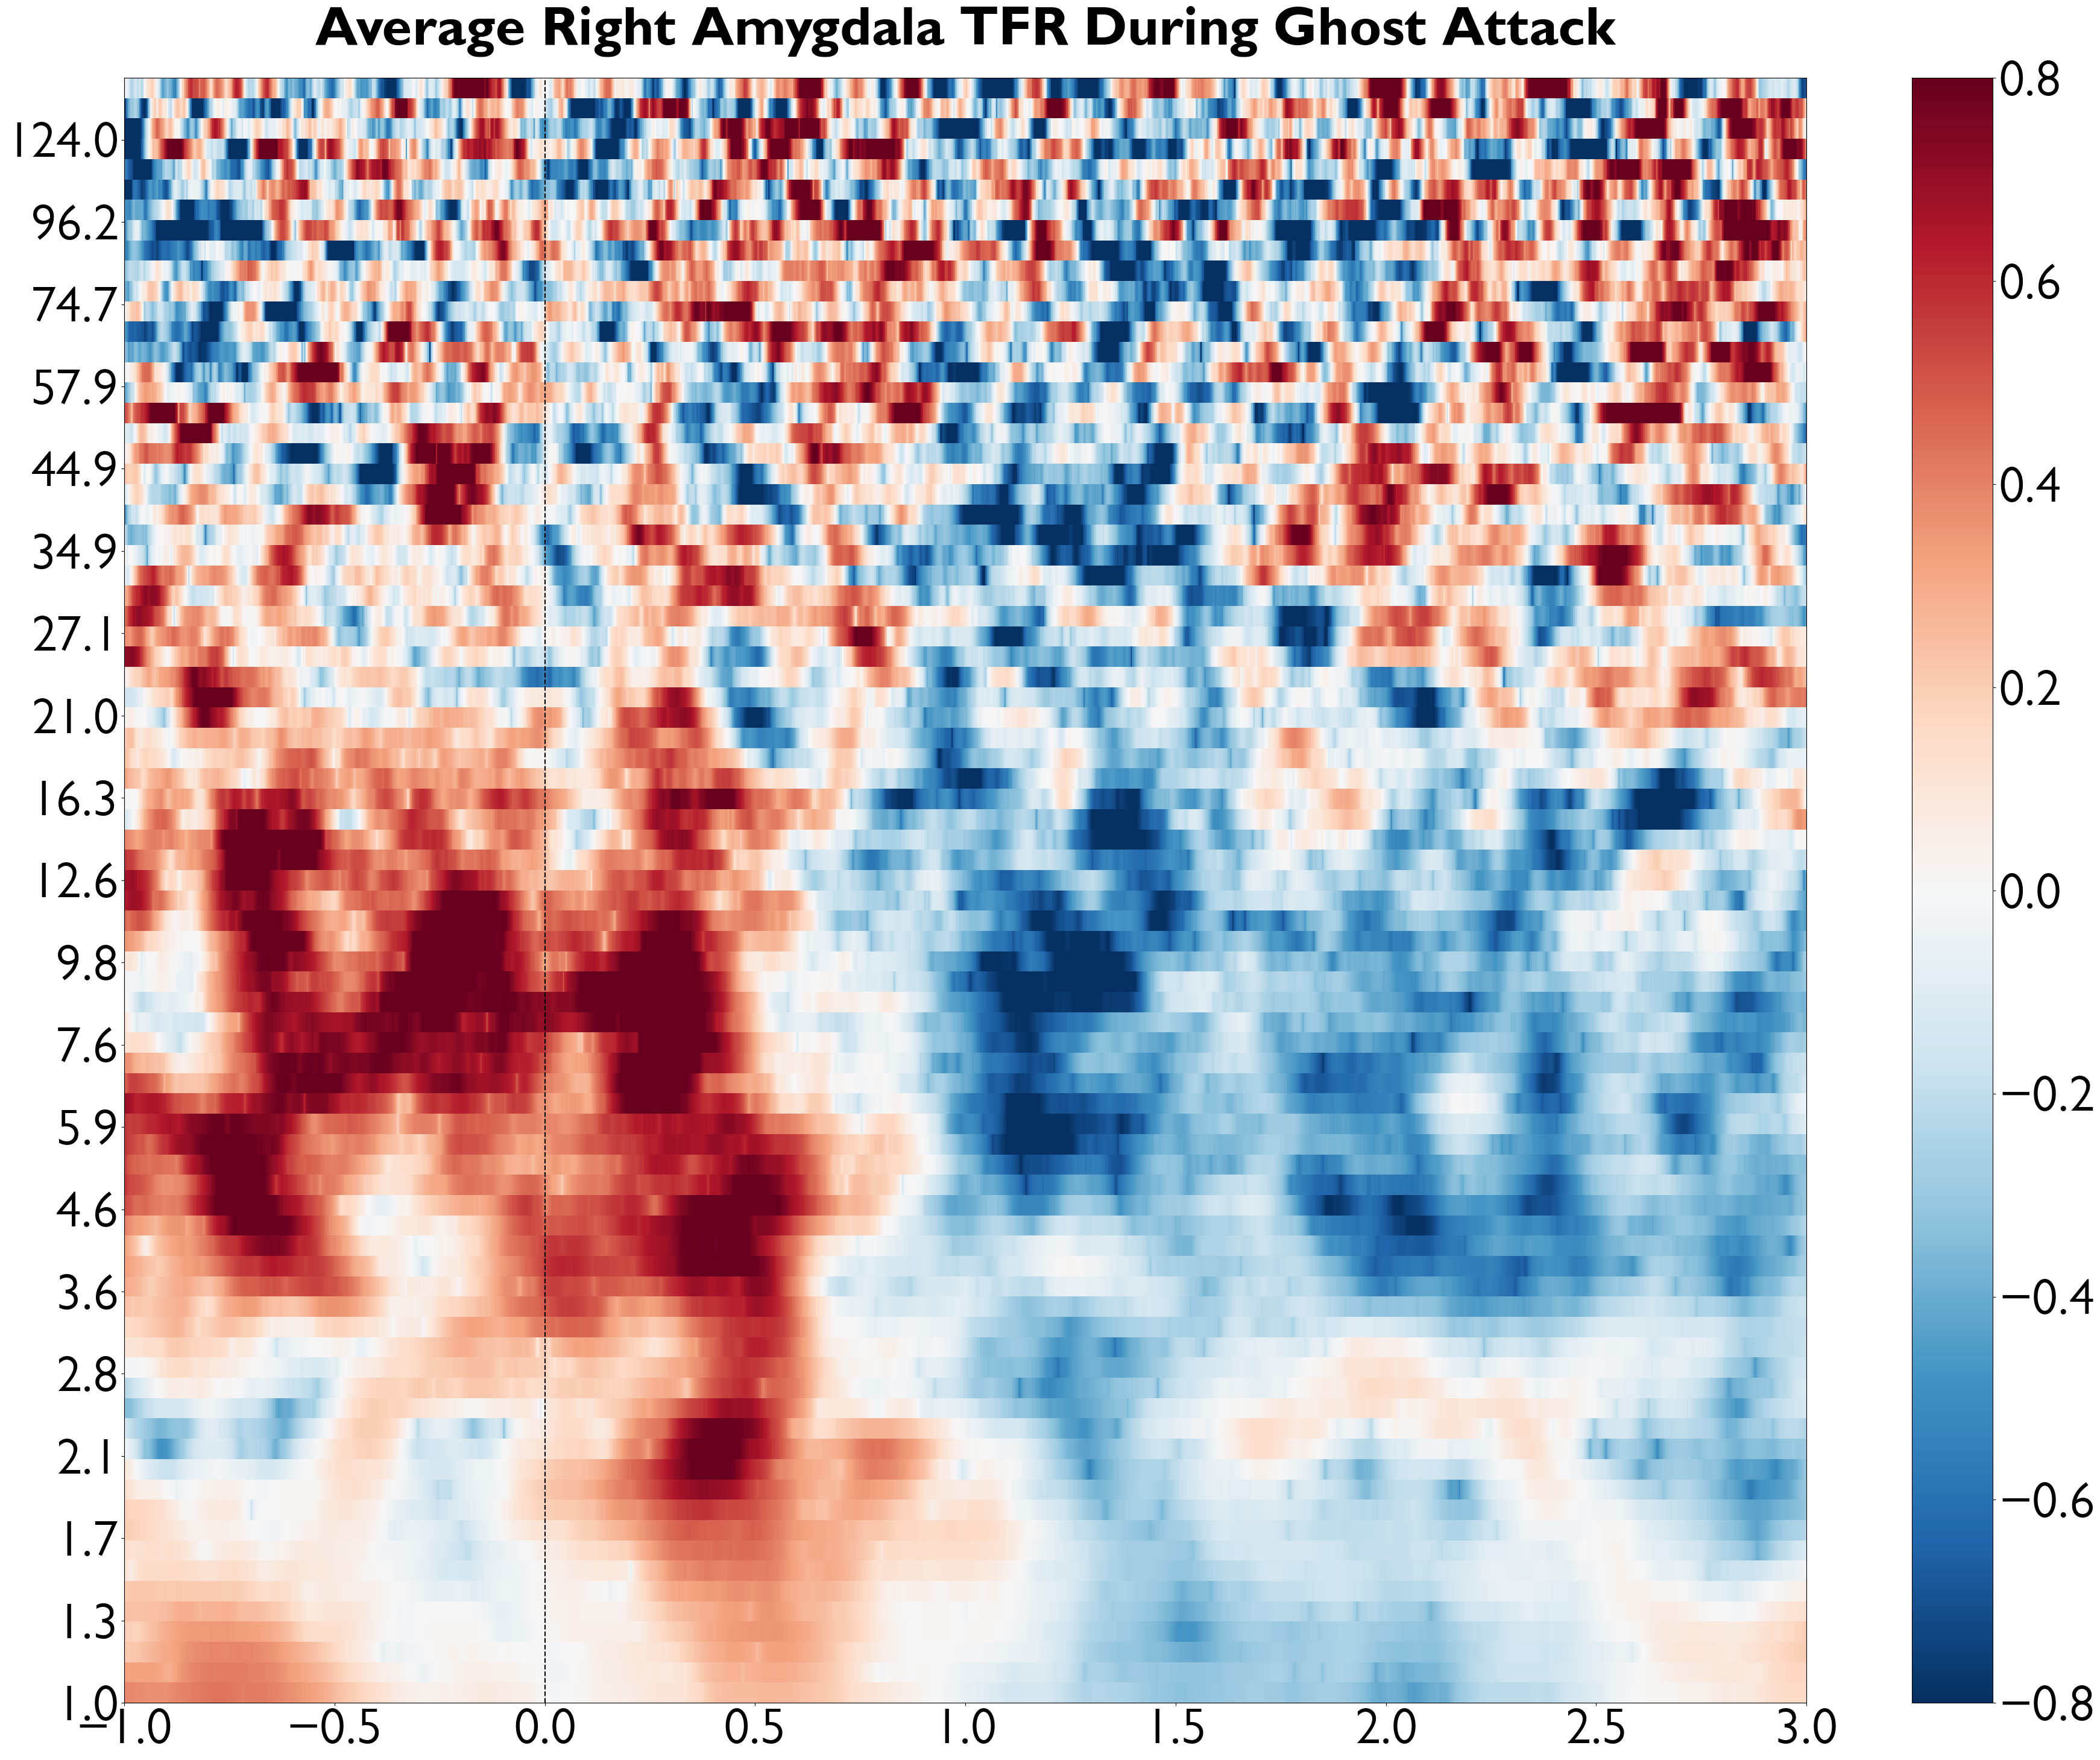

In [21]:
plot_allsub_averages(all_subs_average_amyg_conflict, "Average Right Amygdala TFR During Ghost Attack", 'average_Ramyg_ghost_attack_all_subs.png', -1, 3)

## Insula

In [ ]:
all_subs_average_insulas = calculate_ghost_attack_average(sub_list, conditions, 'insula')
all_subs_average_insula_conflict = all_subs_average_insulas[0]


In [ ]:
plot_allsub_averages(all_subs_average_insula_conflict, "Average Insula TFR During Ghost Attack", 'average_insula_ghost_attack_all_subs.png', -1, 3)

## EC

In [ ]:
all_subs_average_ecs = calculate_ghost_attack_average(sub_list, conditions, 'ec')
all_subs_average_ec_conflict = all_subs_average_ecs[0]


In [ ]:
plot_allsub_averages(all_subs_average_ec_conflict, "Average Entorhinal Cortex TFR During Ghost Attack", 'average_ec_ghost_attack_all_subs.png', -1, 3)